# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# magic word for producing visualizations in notebook
%matplotlib inline

from prettytable import PrettyTable
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
current_wd = os.getcwd()

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
def read_csv_file(path_to_file):
    delimiter = ';'
    missing_values_type_list = ["n/a", "na", "--", " ", "?", "None", "-", "NONE", "none", "NA", "N/A", "inf", "INF", "Inf"]
    df = pd.read_csv(path_to_file, sep=delimiter, na_values = missing_values_type_list) 
    return df

In [4]:
#Load in the general demographics data.
azdias_file_path = current_wd + '/Udacity_AZDIAS_Subset.csv'
azdias_df = read_csv_file(azdias_file_path)  # data frame for exploring the methods of data cleaning
azdias_df_clustering_copy = read_csv_file(azdias_file_path) # data frame that will be used for dimension reduction and clustering, 

In [5]:
feat_info_file_path = current_wd + '/AZDIAS_Feature_Summary.csv'
feat_info_df = read_csv_file(feat_info_file_path)

In [6]:
#Get info on how the features are were collected and defined
md_file_path = azdias_file_path = current_wd + '/Data_Dictionary.md'
md_file = open(md_file_path,'r')
file_text = md_file.readlines()
for text in file_text:
    print(text)
md_file.close()

# Data Dictionary for Identify Customer Segments Data



## Introduction



The data for this project consist of two files:



- Udacity_AZDIAS_Subset.csv: demographics data for the general population of

      Germany; 891211 persons (rows) x 85 features (columns)

- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order

      company; 191652 persons (rows) x 85 features (columns)



The columns in the general demographics file and customers data file are the

same. This file documents the features that appear in the data files, sorted in

order of appearance. Sections of this file is based on the level of measurement

of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of

feature attributes, including information level, data type, and codes for

missing or unknown values.



### Table of Contents



 1. Person-level features

 2. Household-level features

 3. Building-level features

 4. RR4 micro-cell features

 5. RR3 micro-cell featur

In [7]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
display(azdias_df.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
azdias_df.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [9]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [10]:
display(feat_info_df.head(85))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [11]:
feat_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
class DataPresenter:
    def __init__(self):
        pass
    
    def do_count_plot(self, df_few, df_high,columns_list):
        count_for_figures = 0
        for col in columns_list:
            if col in df_few.columns and col in df_high.columns:
                count_for_figures = count_for_figures + 1
        
        fig, axs = plt.subplots(count_for_figures, 2)
        row_idx_in_subplot = 0
        for column in columns_list:
            print(column)
            if column in df_few.columns and column in df_high.columns:
                display(df_few[column])
                display(df_high[column])
                sns.countplot(df_few[column], ax=axs[row_idx_in_subplot, 0])
                sns.countplot(df_high[column], ax=axs[row_idx_in_subplot, 1])
                row_idx_in_subplot = row_idx_in_subplot + 1
        
            for ax in axs.flat:
                ax.label_outer()
            
class CleanedDataManager:
    def __init__(self):
        self.nanModifiedData_df = None
        
    def AppendDataValue(self,
                        column_name, 
                        dataFrameWithMissingData,
                        missingDataCountsDict,
                        missing_data_encoding,
                        column_type
                       ):
        
        missing_data_count = 0
        row_idx = 0
        column_data = dataFrameWithMissingData[column_name]
        self.nanModifiedData_df = dataFrameWithMissingData
        splited = missing_data_encoding.split(',')
        if len(missing_data_encoding) > 0:
            splited = missing_data_encoding.split(',')
        for value in column_data:
            value_as_str = str(value)
            value_as_str.strip()
            if value_as_str in splited:
                dataFrameWithMissingData.at[row_idx,column_name] = None
                missing_data_count = missing_data_count + 1
            elif value_as_str[0].isdigit() and len(value_as_str) > 2:
                search_key = '.'
                if value_as_str[1] == search_key:
                    value_as_str_loc_loc = str(value_as_str[0]) 
                    if value_as_str_loc_loc in splited:
                        dataFrameWithMissingData.at[row_idx,column_name] = None
                        missing_data_count = missing_data_count + 1
            elif len(value_as_str) >= 2 and value_as_str[0].isdigit() == True:
                  if value_as_str[1] == 'A' or  \
                     value_as_str[1] == 'B' or  \
                     value_as_str[1] == 'C' or  \
                     value_as_str[1] == 'D' or  \
                     value_as_str[1] == 'E' or  \
                     value_as_str[1] == 'F' :
                            pass
            elif value_as_str[0] != 'X' and \
                 value_as_str[0] != 'W' and \
                 value_as_str[0] != 'O'  and \
                 math.isnan(float(value_as_str)):
                 missing_data_count = missing_data_count + 1
            row_idx = row_idx + 1
        missingDataCountsDict[column_name] = missing_data_count
            
    def RemoveNanColumns(self, ratio_dict, lower_bound):
        #self.copyDf()
        col_count_at_start = len(self.nanModifiedData_df.columns)
        for key in ratio_dict.keys():
            ratio_loc = ratio_dict[key]
            if ratio_loc > lower_bound: #columns with missing data greater than 20% should be dropped
                self.nanModifiedData_df.drop(key, axis=1, inplace=True)
        col_count_at_end = len(self.nanModifiedData_df.columns)
        print(col_count_at_start - col_count_at_end, ':', ' columns were dropped!')
        return self.nanModifiedData_df
    
class AttributeMissingDataInfo:
    def __init__(self):
        self.attribute = None
        self.missing_data_encoding = None
        self.information_level = None
        self.attribute_type = None
        
    def setAttribute(self, attribute):
        self.attribute = attribute
    
    def setInformationLevel(self, information_level):
        self.information_level = information_level
    
    def setAttributeType(self, attribute_type):
        self.attribute_type = attribute_type
        
    def processAndAddEncoding(self, missing_data_encoding_str):
        start = 1
        length = len(missing_data_encoding_str)
        stop = length - 1
        val = missing_data_encoding_str[start:stop]
        self.missing_data_encoding = str(val)
        
class RawDataManager:
    def __init__(self):
        self.attributeMissingDataInfoList = list()
        self.missingDataCountsDict = dict()
        
        row_names = feat_info_df.index.values
        for idx, row in feat_info_df.iterrows():
            attributeMissingDataInfo = AttributeMissingDataInfo()
            attributeMissingDataInfo.setAttribute(row["attribute"])
            attributeMissingDataInfo.setAttributeType(row["type"])
            attributeMissingDataInfo.setInformationLevel(row["information_level"])
            attributeMissingDataInfo.processAndAddEncoding(row["missing_or_unknown"])
            self.attributeMissingDataInfoList.append(attributeMissingDataInfo)
            
    def printInfo(self):
        for attributeMissingDataInfo in self.attributeMissingDataInfoList:
            print(attributeMissingDataInfo.attribute)
            print(attributeMissingDataInfo.missing_data_encoding)
        
    def convertMissingValuesToNAN(self, dataFrameWithMissingData,  cleanedDataManager):
        for attributeMissingDataInfo in self.attributeMissingDataInfoList:
            cleanedDataManager.AppendDataValue(
                                               attributeMissingDataInfo.attribute, 
                                               dataFrameWithMissingData,
                                               self.missingDataCountsDict,
                                               attributeMissingDataInfo.missing_data_encoding,
                                               attributeMissingDataInfo.attribute_type
                                              )
    def displayConvertedData(self, cleanedDataManager):
        cleanedDataManager.DisplayNanModifiedData(50)

In [13]:
def convert_missing_to_nan(df_in, cleanedDataManager, rawDataManager):
    rawDataManager.convertMissingValuesToNAN(df_in, cleanedDataManager)
    return cleanedDataManager.nanModifiedData_df

In [14]:
def do_convert_missing(df, cleanedDataManager, rawDataManager):
    nanModifiedData_azdias_df = convert_missing_to_nan(df, cleanedDataManager, rawDataManager)
    attributes_list = rawDataManager.attributeMissingDataInfoList
    display(nanModifiedData_azdias_df)
    return (attributes_list, nanModifiedData_azdias_df)

In [15]:
# Identify missing or unknown data values and convert them to NaNs.
rawDataManager_azdias_df = RawDataManager()
cleanedDataManager_azdias_df = CleanedDataManager()
attributes_list, nanModifiedData_azdias_df = do_convert_missing(azdias_df, cleanedDataManager_azdias_df, rawDataManager_azdias_df)
display(nanModifiedData_azdias_df)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [16]:
nanModifiedData_azdias_df.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
nanModifiedData_azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def assess_missing_data_in_columns(rawDataManager_in, df_in):
    missing_data_count_per_column = rawDataManager_in.missingDataCountsDict
    
    keys = missing_data_count_per_column.keys()
    
    total_number_of_data_per_column = len(df_in.index)

    ratio_dict = dict()
    for key in keys:
        count_for_missing_data = missing_data_count_per_column[key]
        ratio = math.ceil(100*count_for_missing_data / total_number_of_data_per_column)
        ratio_dict[key] = ratio

    return ratio_dict

In [19]:
def assess_missing_first_trial(rawDataManager_in, df_in):
    ratio_dict = assess_missing_data_in_columns(rawDataManager_in, df_in)
    
    pretty_table = PrettyTable()
    pretty_table .field_names = ["Column","Percentage Missing Data [%]"]
    
    sorted_ratio_dict = sorted(ratio_dict, key=ratio_dict.__getitem__) # sort the keys using the values
    for key in sorted_ratio_dict:
        value = ratio_dict[key]
        pretty_table.add_row([key, value])
    bin_edges = range(0, 120)
    plt.hist(ratio_dict.values(), bins=bin_edges)
    plt.ylabel('Counts per bin')
    plt.show()
    
    print(pretty_table)
    
    return ratio_dict

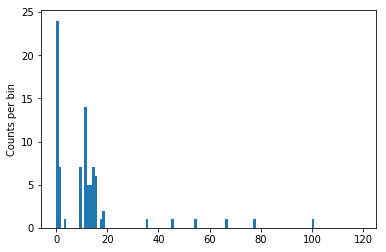

+-----------------------+-----------------------------+
|         Column        | Percentage Missing Data [%] |
+-----------------------+-----------------------------+
|       ANREDE_KZ       |              0              |
|   FINANZ_MINIMALIST   |              0              |
|     FINANZ_SPARER     |              0              |
|    FINANZ_VORSORGER   |              0              |
|     FINANZ_ANLEGER    |              0              |
| FINANZ_UNAUFFAELLIGER |              0              |
|    FINANZ_HAUSBAUER   |              0              |
|       FINANZTYP       |              0              |
|    GREEN_AVANTGARDE   |              0              |
|       SEMIO_SOZ       |              0              |
|       SEMIO_FAM       |              0              |
|       SEMIO_REL       |              0              |
|       SEMIO_MAT       |              0              |
|       SEMIO_VERT      |              0              |
|       SEMIO_LUST      |              0        

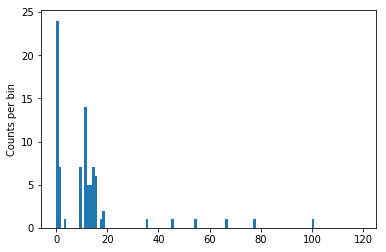

+-----------------------+-----------------------------+
|         Column        | Percentage Missing Data [%] |
+-----------------------+-----------------------------+
|       ANREDE_KZ       |              0              |
|   FINANZ_MINIMALIST   |              0              |
|     FINANZ_SPARER     |              0              |
|    FINANZ_VORSORGER   |              0              |
|     FINANZ_ANLEGER    |              0              |
| FINANZ_UNAUFFAELLIGER |              0              |
|    FINANZ_HAUSBAUER   |              0              |
|       FINANZTYP       |              0              |
|    GREEN_AVANTGARDE   |              0              |
|       SEMIO_SOZ       |              0              |
|       SEMIO_FAM       |              0              |
|       SEMIO_REL       |              0              |
|       SEMIO_MAT       |              0              |
|       SEMIO_VERT      |              0              |
|       SEMIO_LUST      |              0        

In [20]:
ratio_dict = assess_missing_first_trial(rawDataManager_azdias_df, nanModifiedData_azdias_df)

# Below is for comparing with the above function call only.
pretty_table = PrettyTable()
pretty_table .field_names = ["Column","Percentage Missing Data [%]"]

sorted_ratio_dict = sorted(ratio_dict, key=ratio_dict.__getitem__) # sort the keys using the values
for key in sorted_ratio_dict:
    value = ratio_dict[key]
    pretty_table.add_row([key, value])
    
bin_edges = range(0, 120)
plt.hist(ratio_dict.values(), bins=bin_edges)
plt.ylabel('Counts per bin')
plt.show()

print(pretty_table)

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
df_with_dropped_cols = cleanedDataManager_azdias_df.RemoveNanColumns(ratio_dict, 20) #Remove columns with more than 20% missing data  based on the histogram shown above
df_with_dropped_cols.info()

6 :  columns were dropped!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float6

#### Discussion 1.1.2: Assess Missing Data in Each Column

As seen in the table of computed percentage of nans for each feature in the table above and the histogram, we see that the followings:
24 features have no or have nearly zero percentage nans.
7  features have about 7% nans
1 feature has about 3% nans
7 features have about 9% nans
14 features have about 11% nans
5 features have about 12% nans
5 features have about 13% nans
7 features have about 14% nans
6 features have about 15% nans
1 feature have about 17% nans
2 features have about 18% nans
1 feature have about 35% nans
1 feature have about 45% nans
1 feature have about 54% nans
1 feature have about 66% nans
1 feature have about 77% nans
1 feature have about 100% nans

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# How much data is missing in each row of the dataset?
def count_nan_in_rows(df_in):
    row_nan_dict = dict()
    nan_counts = 0
    for idx in  df_in.index:
        for column in df_in.columns:
            value = df_in.at[idx,column]
            value_as_str = str(value)
            if value_as_str.isalpha():
                value_as_str = value_as_str.lower()    
                if value_as_str == 'nan':
                    nan_counts = nan_counts + 1
                elif value_as_str == 'None' or value_as_str == None:
                     nan_counts = nan_counts + 1
        row_nan_dict[idx] = nan_counts
        nan_counts = 0
    return row_nan_dict 


row_nan_dict = count_nan_in_rows(df_with_dropped_cols)

In [23]:
def get_missing_as_ratios(dict_in, df_in):
    row_ratio_dict = dict()
    total_number_of_rows = len(df_in.columns)
    for key in dict_in.keys():
        count_for_missing_data = dict_in[key]
        ratio = 100*count_for_missing_data / total_number_of_rows
        row_ratio_dict[key] = ratio
    return row_ratio_dict 

row_ratio_dict = get_missing_as_ratios(row_nan_dict, df_with_dropped_cols)

In [24]:
# Write code to divide the data into two subsets based on the number of missing
#def partition_df(df_in, dict_in):
def partition_ratio_dict(dict_in):
    epsilon = 1E-15
    few_missing_row_data_list = list()
    high_missing_row_data_list = list()
    for key in dict_in.keys():
        value = dict_in[key] 
        if value - 12 <= epsilon: # lowest bound is 12%
            few_missing_row_data_list.append(key)
        else:
            high_missing_row_data_list.append(key)
    return (few_missing_row_data_list, high_missing_row_data_list)

partitioned_list_pair = partition_ratio_dict(row_ratio_dict)

In [25]:
def partition_df_into_two(list_pair, df):
    nanModifiedData_azdias_df.info()
    few_missing_row_data_df_loc = nanModifiedData_azdias_df.loc[list_pair[0],:] # for rows with low number of nans
    high_missing_row_data_df_loc = nanModifiedData_azdias_df.loc[list_pair[1],:] # for rows with high number of nans
    return(few_missing_row_data_df_loc, high_missing_row_data_df_loc)

partitioned_df_pair = partition_df_into_two(partitioned_list_pair, df_with_dropped_cols)

few_missing_row_data_df = partitioned_df_pair[0]
high_missing_row_data_df = partitioned_df_pair[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [26]:
def present_data(few_missing_row_data_df, high_missing_row_data_df, columns_list): 
    dataPresenter = DataPresenter()
    dataPresenter.do_count_plot(few_missing_row_data_df, high_missing_row_data_df, columns_list)

GREEN_AVANTGARDE


1         0
2         1
3         0
4         0
5         0
6         0
7         0
8         1
9         1
10        0
12        0
13        1
15        0
16        0
18        0
19        1
21        0
22        0
23        1
25        0
27        1
28        0
29        1
31        0
32        1
33        0
34        1
36        0
37        0
38        0
         ..
891190    1
891191    0
891192    0
891193    0
891194    1
891195    0
891196    0
891197    1
891198    1
891199    0
891200    0
891201    0
891202    0
891204    0
891205    0
891206    0
891207    1
891208    0
891209    0
891210    0
891211    0
891212    0
891213    1
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Name: GREEN_AVANTGARDE, Length: 774791, dtype: int64

0         0
11        0
14        0
17        0
20        1
24        0
26        0
30        0
35        0
46        0
48        0
53        0
54        0
61        0
62        0
69        0
75        0
76        0
81        0
83        0
90        0
97        0
99        0
103       0
106       0
108       0
109       0
112       0
133       0
137       0
         ..
891049    0
891055    0
891061    0
891062    0
891063    0
891064    0
891069    0
891072    0
891074    0
891092    0
891095    0
891100    0
891117    0
891119    0
891120    0
891130    0
891137    0
891140    0
891154    0
891159    0
891164    0
891169    0
891170    0
891171    0
891172    0
891173    0
891175    0
891185    0
891187    0
891203    0
Name: GREEN_AVANTGARDE, Length: 116430, dtype: int64

CJT_GESAMTTYP


1         5.0
2         3.0
3         2.0
4         5.0
5         2.0
6         5.0
7         3.0
8         3.0
9         4.0
10        1.0
12        6.0
13        5.0
15        4.0
16        1.0
18        6.0
19        3.0
21        3.0
22        4.0
23        3.0
25        3.0
27        4.0
28        2.0
29        1.0
31        6.0
32        4.0
33        4.0
34        2.0
36        2.0
37        2.0
38        6.0
         ... 
891190    1.0
891191    1.0
891192    3.0
891193    3.0
891194    4.0
891195    6.0
891196    6.0
891197    1.0
891198    5.0
891199    3.0
891200    3.0
891201    3.0
891202    5.0
891204    5.0
891205    2.0
891206    4.0
891207    1.0
891208    2.0
891209    5.0
891210    5.0
891211    2.0
891212    1.0
891213    5.0
891214    4.0
891215    6.0
891216    5.0
891217    4.0
891218    4.0
891219    3.0
891220    1.0
Name: CJT_GESAMTTYP, Length: 774791, dtype: float64

0         2.0
11        6.0
14        6.0
17        6.0
20        4.0
24        6.0
26        3.0
30        3.0
35        2.0
46        3.0
48        6.0
53        3.0
54        6.0
61        6.0
62        4.0
69        6.0
75        6.0
76        2.0
81        5.0
83        4.0
90        4.0
97        6.0
99        6.0
103       6.0
106       1.0
108       6.0
109       4.0
112       6.0
133       6.0
137       6.0
         ... 
891049    6.0
891055    6.0
891061    3.0
891062    3.0
891063    2.0
891064    6.0
891069    6.0
891072    6.0
891074    4.0
891092    6.0
891095    6.0
891100    3.0
891117    1.0
891119    3.0
891120    4.0
891130    5.0
891137    4.0
891140    1.0
891154    1.0
891159    1.0
891164    4.0
891169    1.0
891170    4.0
891171    5.0
891172    1.0
891173    1.0
891175    6.0
891185    6.0
891187    6.0
891203    1.0
Name: CJT_GESAMTTYP, Length: 116430, dtype: float64

GFK_URLAUBERTYP


1         10.0
2         10.0
3          1.0
4          5.0
5          1.0
6         12.0
7          9.0
8          3.0
9         12.0
10         8.0
12        10.0
13        12.0
15        12.0
16        10.0
18        11.0
19         8.0
21        11.0
22         4.0
23        12.0
25         1.0
27         8.0
28         1.0
29         5.0
31         1.0
32        10.0
33         5.0
34         5.0
36         5.0
37         5.0
38         1.0
          ... 
891190     3.0
891191     6.0
891192    10.0
891193     4.0
891194     9.0
891195     5.0
891196    12.0
891197     5.0
891198    10.0
891199    11.0
891200    12.0
891201     7.0
891202    10.0
891204    11.0
891205     5.0
891206    12.0
891207     8.0
891208    10.0
891209     9.0
891210     4.0
891211     1.0
891212     4.0
891213     8.0
891214    10.0
891215    12.0
891216    12.0
891217     1.0
891218    10.0
891219     9.0
891220    12.0
Name: GFK_URLAUBERTYP, Length: 774791, dtype: float64

0         10.0
11         5.0
14         5.0
17         5.0
20        11.0
24         5.0
26         2.0
30        11.0
35         7.0
46         1.0
48         5.0
53         9.0
54         5.0
61         1.0
62         9.0
69         5.0
75         5.0
76         1.0
81        11.0
83         8.0
90         1.0
97         5.0
99         5.0
103        5.0
106       12.0
108        5.0
109       11.0
112        5.0
133        5.0
137        5.0
          ... 
891049     5.0
891055     8.0
891061    12.0
891062    12.0
891063     9.0
891064     5.0
891069     4.0
891072     5.0
891074     9.0
891092     5.0
891095     5.0
891100     3.0
891117    12.0
891119    12.0
891120     2.0
891130     2.0
891137    12.0
891140     8.0
891154     5.0
891159    10.0
891164     2.0
891169     2.0
891170    10.0
891171    10.0
891172     9.0
891173     2.0
891175     5.0
891185     5.0
891187     5.0
891203     8.0
Name: GFK_URLAUBERTYP, Length: 116430, dtype: float64

LP_LEBENSPHASE_FEIN


1         21.0
2          3.0
3          NaN
4         32.0
5          8.0
6          2.0
7          5.0
8         10.0
9          4.0
10         6.0
12        23.0
13         3.0
15        12.0
16         NaN
18        10.0
19        20.0
21        10.0
22         1.0
23        20.0
25         NaN
27        25.0
28         5.0
29        13.0
31         2.0
32        18.0
33        31.0
34        13.0
36         5.0
37        38.0
38        10.0
          ... 
891190    13.0
891191     8.0
891192    29.0
891193    16.0
891194    28.0
891195    32.0
891196    25.0
891197    13.0
891198     3.0
891199     2.0
891200    29.0
891201     4.0
891202     2.0
891204    34.0
891205    31.0
891206    10.0
891207    20.0
891208    19.0
891209    29.0
891210     5.0
891211     5.0
891212     6.0
891213    36.0
891214     2.0
891215     2.0
891216     2.0
891217     2.0
891218     NaN
891219    29.0
891220     6.0
Name: LP_LEBENSPHASE_FEIN, Length: 774791, dtype: float64

0         15.0
11         NaN
14         NaN
17         NaN
20        10.0
24         NaN
26        11.0
30         7.0
35        19.0
46         NaN
48         NaN
53        33.0
54         NaN
61        22.0
62         1.0
69         NaN
75         NaN
76        37.0
81         NaN
83        14.0
90         1.0
97         NaN
99         NaN
103        NaN
106        6.0
108        NaN
109        5.0
112        NaN
133        NaN
137        NaN
          ... 
891049     NaN
891055    31.0
891061    11.0
891062     2.0
891063     6.0
891064     NaN
891069     6.0
891072     NaN
891074     1.0
891092     NaN
891095     NaN
891100    31.0
891117    12.0
891119    14.0
891120    10.0
891130    25.0
891137    15.0
891140     6.0
891154    12.0
891159    23.0
891164    28.0
891169     NaN
891170    18.0
891171     7.0
891172    25.0
891173    16.0
891175     NaN
891185     NaN
891187     NaN
891203     NaN
Name: LP_LEBENSPHASE_FEIN, Length: 116430, dtype: float64

LP_LEBENSPHASE_GROB


1          6.0
2          1.0
3          NaN
4         10.0
5          2.0
6          1.0
7          2.0
8          3.0
9          1.0
10         2.0
12         6.0
13         1.0
15         3.0
16         NaN
18         3.0
19         5.0
21         3.0
22         1.0
23         5.0
25         NaN
27         7.0
28         2.0
29         3.0
31         1.0
32         5.0
33        10.0
34         3.0
36         2.0
37        12.0
38         3.0
          ... 
891190     3.0
891191     2.0
891192     9.0
891193     4.0
891194     8.0
891195    10.0
891196     7.0
891197     3.0
891198     1.0
891199     1.0
891200     9.0
891201     1.0
891202     1.0
891204    11.0
891205    10.0
891206     3.0
891207     5.0
891208     5.0
891209     9.0
891210     2.0
891211     2.0
891212     2.0
891213    12.0
891214     1.0
891215     1.0
891216     1.0
891217     1.0
891218     NaN
891219     9.0
891220     2.0
Name: LP_LEBENSPHASE_GROB, Length: 774791, dtype: float64

0          4.0
11         NaN
14         NaN
17         NaN
20         3.0
24         NaN
26         3.0
30         2.0
35         5.0
46         NaN
48         NaN
53        11.0
54         NaN
61         6.0
62         1.0
69         NaN
75         NaN
76        12.0
81         NaN
83         4.0
90         1.0
97         NaN
99         NaN
103        NaN
106        2.0
108        NaN
109        2.0
112        NaN
133        NaN
137        NaN
          ... 
891049     NaN
891055    10.0
891061     3.0
891062     1.0
891063     2.0
891064     NaN
891069     2.0
891072     NaN
891074     1.0
891092     NaN
891095     NaN
891100    10.0
891117     3.0
891119     4.0
891120     3.0
891130     7.0
891137     4.0
891140     2.0
891154     3.0
891159     6.0
891164     8.0
891169     NaN
891170     5.0
891171     2.0
891172     7.0
891173     4.0
891175     NaN
891185     NaN
891187     NaN
891203     NaN
Name: LP_LEBENSPHASE_GROB, Length: 116430, dtype: float64

LP_FAMILIE_FEIN


1          5.0
2          1.0
3          NaN
4         10.0
5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
10         1.0
12         5.0
13         1.0
15         1.0
16         NaN
18         1.0
19         2.0
21         1.0
22         1.0
23         2.0
25         NaN
27         7.0
28         1.0
29         1.0
31         1.0
32         2.0
33        11.0
34         1.0
36         1.0
37        10.0
38         1.0
          ... 
891190     1.0
891191     1.0
891192    10.0
891193     2.0
891194     7.0
891195    10.0
891196     7.0
891197     1.0
891198     1.0
891199     1.0
891200    10.0
891201     1.0
891202     1.0
891204    11.0
891205    10.0
891206     1.0
891207     2.0
891208     2.0
891209    10.0
891210     1.0
891211     1.0
891212     1.0
891213    11.0
891214     1.0
891215     1.0
891216     1.0
891217     1.0
891218     NaN
891219     9.0
891220     1.0
Name: LP_FAMILIE_FEIN, Length: 774791, dtype: float64

0          2.0
11         NaN
14         NaN
17         NaN
20         1.0
24         NaN
26         1.0
30         1.0
35         2.0
46         1.0
48         NaN
53        10.0
54         NaN
61         3.0
62         1.0
69         NaN
75         NaN
76        10.0
81         1.0
83         2.0
90         1.0
97         NaN
99         NaN
103        NaN
106        1.0
108        NaN
109        1.0
112        NaN
133        NaN
137        NaN
          ... 
891049     NaN
891055    10.0
891061     1.0
891062     1.0
891063     1.0
891064     NaN
891069     1.0
891072     NaN
891074     1.0
891092     NaN
891095     NaN
891100    10.0
891117     1.0
891119     2.0
891120     1.0
891130     6.0
891137     2.0
891140     1.0
891154     1.0
891159     3.0
891164     6.0
891169     NaN
891170     2.0
891171     1.0
891172     7.0
891173     2.0
891175     NaN
891185     NaN
891187     NaN
891203     NaN
Name: LP_FAMILIE_FEIN, Length: 116430, dtype: float64

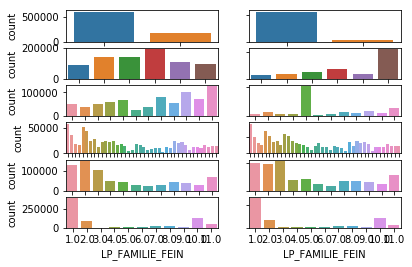

In [27]:
cols_list = ['GREEN_AVANTGARDE', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN']
present_data(few_missing_row_data_df, high_missing_row_data_df, cols_list)


#### Discussion 1.1.3: Assess Missing Data in Each Row
In the bar plots above, we have dat for the data with high number of nans to the rght while the data frame with few or zero number of nans are plotted to the left. There differences in the distributions in ech row of the bar plots but one safely use the data frame with few or zero number of nans for the analysis that follows.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
#How many features are there of each data type?
# First get values to be used for the computations, use this since we have a complete table without empty rows
def access_how_many_features(attributes_list_in, column_name, pretty_table_types_classification, pretty_table_categorical_variables):
    ordinal_cnt = 0
    mixed_cnt = 0
    categorical_cnt = 0
    numeric_cnt = 0
    interval_type_cnt = 0
    type_list = ['ordinal', 'categorical', 'numeric', 'mixed', 'interval']
    to_be_droped = list()
    pretty_table_types_classification.field_names = ['Attribute Name', 'Attribute Type']
    pretty_table_categorical_variables.field_names = ['Attribute Name', 'Attribute Type', 'Level', 'Re-encode']
    binary_categorical_variables = ['OST_WEST_KZ', 'ANREDE_KZ', 'SOHO_KZ', 'VERS_TYP', 'GREEN_AVANTGARDE']
    for attribute in attributes_list_in:
        attribute_type = attribute.attribute_type
        if attribute_type == 'ordinal':
            ordinal_cnt = ordinal_cnt + 1
        elif attribute_type == 'categorical':
            level = 'multi level'
            re_encode = False
            if attribute.attribute in binary_categorical_variables:
                level = 'binary'
                re_encode = False
                if attribute.attribute == column_name:
                    re_encode = True
            else:
                to_be_droped.append(attribute.attribute)
            pretty_table_categorical_variables.add_row([attribute.attribute, attribute_type, level, re_encode])
            categorical_cnt = categorical_cnt + 1 
        elif attribute_type == 'numeric':
             numeric_cnt = numeric_cnt + 1
        elif attribute_type == 'mixed':
             mixed_cnt = mixed_cnt + 1 
        elif attribute_type == 'interval':
             interval_type_cnt  = interval_type_cnt  + 1 
        pretty_table_types_classification.add_row([attribute.attribute, attribute_type])
    pretty_table_types_classification.sortby = 'Attribute Type'
    pretty_table_types_count = PrettyTable()
    pretty_table_types_count.field_names = ['Type', 'Count']
    for attribute_type in type_list:
        if attribute_type == 'ordinal':
            pretty_table_types_count.add_row([attribute_type, ordinal_cnt])
        elif attribute_type == 'categorical':
            pretty_table_types_count.add_row([attribute_type, categorical_cnt])
        elif attribute_type == 'numeric':
            pretty_table_types_count.add_row([attribute_type, numeric_cnt])
        elif attribute_type == 'mixed':
            pretty_table_types_count.add_row([attribute_type, mixed_cnt])
        elif attribute_type == 'interval':
            pretty_table_types_count.add_row([attribute_type, interval_type_cnt])

    pretty_table_types_count.sortby = 'Count'
    print(pretty_table_types_count)
    print(pretty_table_types_classification)
    return to_be_droped

pretty_table_types_classification = PrettyTable()
pretty_table_categorical_variables = PrettyTable()
to_be_dropped = access_how_many_features(attributes_list, 'OST_WEST_KZ', pretty_table_types_classification, pretty_table_categorical_variables)

print('print list that is to be dropped')
for column in to_be_dropped:
    print(column)

+-------------+-------+
|     Type    | Count |
+-------------+-------+
|   interval  |   1   |
|    mixed    |   7   |
|   numeric   |   7   |
| categorical |   21  |
|   ordinal   |   49  |
+-------------+-------+
+-----------------------+----------------+
|     Attribute Name    | Attribute Type |
+-----------------------+----------------+
|        AGER_TYP       |  categorical   |
|       ANREDE_KZ       |  categorical   |
|    CAMEO_DEUG_2015    |  categorical   |
|     CAMEO_DEU_2015    |  categorical   |
|     CJT_GESAMTTYP     |  categorical   |
|       FINANZTYP       |  categorical   |
|      GEBAEUDETYP      |  categorical   |
|    GFK_URLAUBERTYP    |  categorical   |
|    GREEN_AVANTGARDE   |  categorical   |
|      KK_KUNDENTYP     |  categorical   |
|    LP_FAMILIE_FEIN    |  categorical   |
|    LP_FAMILIE_GROB    |  categorical   |
|     LP_STATUS_FEIN    |  categorical   |
|     LP_STATUS_GROB    |  categorical   |
|    NATIONALITAET_KZ   |  categorical   |
|      OST

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
def display_table(table_to_be_displayed, sorting_label):
    table_to_be_displayed.sortby = sorting_label
    print(pretty_table_categorical_variables)

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
display_table(pretty_table_categorical_variables, 'Level')

+------------------+----------------+-------------+-----------+
|  Attribute Name  | Attribute Type |    Level    | Re-encode |
+------------------+----------------+-------------+-----------+
|    ANREDE_KZ     |  categorical   |    binary   |   False   |
| GREEN_AVANTGARDE |  categorical   |    binary   |   False   |
|   OST_WEST_KZ    |  categorical   |    binary   |    True   |
|     SOHO_KZ      |  categorical   |    binary   |   False   |
|     VERS_TYP     |  categorical   |    binary   |   False   |
|     AGER_TYP     |  categorical   | multi level |   False   |
| CAMEO_DEUG_2015  |  categorical   | multi level |   False   |
|  CAMEO_DEU_2015  |  categorical   | multi level |   False   |
|  CJT_GESAMTTYP   |  categorical   | multi level |   False   |
|    FINANZTYP     |  categorical   | multi level |   False   |
|   GEBAEUDETYP    |  categorical   | multi level |   False   |
| GFK_URLAUBERTYP  |  categorical   | multi level |   False   |
|   KK_KUNDENTYP   |  categorical   | mu

In [31]:
few_missing_row_data_df.dropna(inplace=True)
few_missing_row_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null int64
CJT_GESAMTTYP            623209 non-null float64
FINANZ_MINIMALIST        623209 non-null int64
FINANZ_SPARER            623209 non-null int64
FINANZ_VORSORGER         623209 non-null int64
FINANZ_ANLEGER           623209 non-null int64
FINANZ_UNAUFFAELLIGER    623209 non-null int64
FINANZ_HAUSBAUER         623209 non-null int64
FINANZTYP                623209 non-null int64
GFK_URLAUBERTYP          623209 non-null float64
GREEN_AVANTGARDE         623209 non-null int64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
LP_FAMILIE_FEIN          623209 non-null float64
LP_FAMILIE_GROB          623209 non-null float64
LP_STATUS_FEIN           623209 non-null float64
LP_STATUS_GROB           

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.
def re_encode_binary(df, column_name, to_be_dropped_in):
    if column_name in df.columns:
        few_missing_row_data_df1 = pd.get_dummies(df[column_name], prefix=column_name)
        few_missing_row_data_df2_loc = pd.concat([df, few_missing_row_data_df1], axis=1)
        few_missing_row_data_df2_loc.drop(column_name, axis=1, inplace=True)
        for column in to_be_dropped_in:
            
            if column in few_missing_row_data_df2_loc.columns:
                few_missing_row_data_df2_loc.drop(column, axis=1, inplace=True)
        return few_missing_row_data_df2_loc

re_encoded_binary = re_encode_binary(few_missing_row_data_df, 'OST_WEST_KZ', to_be_dropped)


In [33]:
few_missing_row_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null int64
CJT_GESAMTTYP            623209 non-null float64
FINANZ_MINIMALIST        623209 non-null int64
FINANZ_SPARER            623209 non-null int64
FINANZ_VORSORGER         623209 non-null int64
FINANZ_ANLEGER           623209 non-null int64
FINANZ_UNAUFFAELLIGER    623209 non-null int64
FINANZ_HAUSBAUER         623209 non-null int64
FINANZTYP                623209 non-null int64
GFK_URLAUBERTYP          623209 non-null float64
GREEN_AVANTGARDE         623209 non-null int64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
LP_FAMILIE_FEIN          623209 non-null float64
LP_FAMILIE_GROB          623209 non-null float64
LP_STATUS_FEIN           623209 non-null float64
LP_STATUS_GROB           

#### Discussion 1.2.1: Re-Encode Categorical Features

To simplify the analysis and processing, I only kept all the binary categorical variables while removing the multlevel categorical variables. The categorical feature: 'OST_WEST_KZ' was re-encoded

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
re_encoded_binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null int64
FINANZ_MINIMALIST        623209 non-null int64
FINANZ_SPARER            623209 non-null int64
FINANZ_VORSORGER         623209 non-null int64
FINANZ_ANLEGER           623209 non-null int64
FINANZ_UNAUFFAELLIGER    623209 non-null int64
FINANZ_HAUSBAUER         623209 non-null int64
GREEN_AVANTGARDE         623209 non-null int64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
PRAEGENDE_JUGENDJAHRE    623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null int64
SEMIO_FAM                623209 non-null int64
SEMIO_REL                623209 non-null int64
SEMIO_MAT                623209 non-null int64
SEMIO_VERT               623209

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def re_engineer_PRAEGENDE_JUGENDJAHRE(df, column_name):
    column_values = df[column_name]
    decade_list = list()
    movement_list = list()
    row_idx = 0 
    dict_store = {1:0, 2:1, 3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    for value in column_values:
        value_loc = dict_store[value]
        decade_list.append(value)
        movement_list.append(value_loc)
    
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = decade_list
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = movement_list
    df.astype({'PRAEGENDE_JUGENDJAHRE_DECADE': 'int64', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT': 'category'})
    df.drop(column_name, axis=1, inplace=True)
    display(df.head(100))
    return df

re_engineered_cat_ord = re_engineer_PRAEGENDE_JUGENDJAHRE(re_encoded_binary, 'PRAEGENDE_JUGENDJAHRE')

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0,1,14.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,1,15.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,8.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0,1,3.0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,0,1,10.0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1.0,4.0,4.0,2.0,5.0,2.0,0,1,8.0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,0,1,11.0,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,0,1,15.0,1
10,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,3.0,0
19,3.0,1,5,2,3,1,3,1,1,3.0,...,2.0,5.0,4.0,4.0,6.0,3.0,0,1,9.0,1


In [36]:
re_engineered_cat_ord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              623209 non-null float64
ANREDE_KZ                         623209 non-null int64
FINANZ_MINIMALIST                 623209 non-null int64
FINANZ_SPARER                     623209 non-null int64
FINANZ_VORSORGER                  623209 non-null int64
FINANZ_ANLEGER                    623209 non-null int64
FINANZ_UNAUFFAELLIGER             623209 non-null int64
FINANZ_HAUSBAUER                  623209 non-null int64
GREEN_AVANTGARDE                  623209 non-null int64
HEALTH_TYP                        623209 non-null float64
LP_LEBENSPHASE_FEIN               623209 non-null float64
LP_LEBENSPHASE_GROB               623209 non-null float64
RETOURTYP_BK_S                    623209 non-null float64
SEMIO_SOZ                         623209 non-null int64
SEMIO_FAM                         623209 non-null int64
SEMIO_REL                         62320

In [37]:
def re_engineer_CAMEO_INTL_2015(df, column_name):
    column_values_1 = df[column_name]
    list_wealth = list()
    list_life_stage = list()
    for value in column_values_1:
        value = int(value)
        list_life_stage.append(value // 10)
        list_wealth.append(value % 10)
    df['CAMEO_INTL_2015_WEALTH'] = list_wealth
    df['CAMEO_INTL_2015_LIFE_STAGE'] = list_life_stage

    df.drop(column_name, axis=1, inplace=True)
    df.astype({'CAMEO_INTL_2015_WEALTH': 'int64', 'CAMEO_INTL_2015_LIFE_STAGE': 'int64'})
    display(df.head(100))
    return df

re_engineered = re_engineer_CAMEO_INTL_2015(re_engineered_cat_ord, 'CAMEO_INTL_2015')


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,0,1,14.0,0,1,5
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,1,15.0,1,4,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,1,8.0,0,3,4
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,1,3.0,0,4,5
6,2.0,2,1,5,1,5,4,3,0,2.0,...,5.0,4.0,6.0,3.0,0,1,10.0,0,2,2
7,1.0,1,3,3,4,1,3,2,0,1.0,...,4.0,2.0,5.0,2.0,0,1,8.0,0,4,1
8,3.0,1,4,4,2,4,2,2,1,3.0,...,3.0,2.0,4.0,3.0,0,1,11.0,1,3,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,3.0,2.0,3.0,1.0,0,1,15.0,1,5,1
10,3.0,2,2,2,5,3,1,5,0,2.0,...,3.0,4.0,6.0,5.0,0,1,3.0,0,1,5
19,3.0,1,5,2,3,1,3,1,1,3.0,...,4.0,4.0,6.0,3.0,0,1,9.0,1,4,3


#### Discussion 1.2.2: Engineer Mixed-Type Features
All mixed type features were kept, the fatures: 'CAMEO_INTL_2015' and "PRAEGENDE_JUGENDJAHRE" were re-engineered. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
re_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 69 columns):
ALTERSKATEGORIE_GROB              623209 non-null float64
ANREDE_KZ                         623209 non-null int64
FINANZ_MINIMALIST                 623209 non-null int64
FINANZ_SPARER                     623209 non-null int64
FINANZ_VORSORGER                  623209 non-null int64
FINANZ_ANLEGER                    623209 non-null int64
FINANZ_UNAUFFAELLIGER             623209 non-null int64
FINANZ_HAUSBAUER                  623209 non-null int64
GREEN_AVANTGARDE                  623209 non-null int64
HEALTH_TYP                        623209 non-null float64
LP_LEBENSPHASE_FEIN               623209 non-null float64
LP_LEBENSPHASE_GROB               623209 non-null float64
RETOURTYP_BK_S                    623209 non-null float64
SEMIO_SOZ                         623209 non-null int64
SEMIO_FAM                         623209 non-null int64
SEMIO_REL                         62320

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
re_engineered.describe()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,...,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000
mean,2.792540,1.511211,3.057793,2.677015,3.451430,2.770220,2.563095,3.169596,0.234626,2.207486,...,3.350438,3.199007,5.394508,3.113073,0.212336,0.787664,9.221536,0.234626,2.875790,3.326605
std,1.026485,0.499875,1.360774,1.469261,1.388873,1.448796,1.372308,1.365483,0.423765,0.758644,...,1.113337,0.989195,2.295721,1.351074,0.408962,0.408962,4.005402,0.423765,1.499305,1.457813
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,3.000000,3.000000,4.000000,2.000000,0.000000,1.000000,6.000000,0.000000,1.000000,2.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,3.000000,3.000000,5.000000,3.000000,0.000000,1.000000,9.000000,0.000000,3.000000,4.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,4.000000,4.000000,7.000000,4.000000,0.000000,1.000000,14.000000,0.000000,4.000000,5.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,5.000000,5.000000,9.000000,5.000000,1.000000,1.000000,15.000000,1.000000,5.000000,5.000000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(df_in, lower_bound):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    rawDataManager_azdias_df_loc = RawDataManager()
    cleanedDataManager_azdias_df_loc = CleanedDataManager()
    attributes_list_df_pair = do_convert_missing(df_in, cleanedDataManager_azdias_df_loc, rawDataManager_azdias_df_loc)
    attributes_list_loc = attributes_list_df_pair[0]
    nanModifiedData_azdias_df_loc = attributes_list_df_pair[1]

    ratio_dict_loc = assess_missing_first_trial(rawDataManager_azdias_df_loc, nanModifiedData_azdias_df_loc)
    df_with_dropped_cols_loc = cleanedDataManager_azdias_df_loc.RemoveNanColumns(ratio_dict_loc,  lower_bound) #Remove columns with more than  lower_bound in % missing data  based on the histogram shown above
    df_with_dropped_cols_loc.info()
    
    row_nan_dict_loc = count_nan_in_rows(df_with_dropped_cols_loc)
    row_ratio_dict_loc = get_missing_as_ratios(row_nan_dict_loc, df_with_dropped_cols_loc)
    partitioned_list_pair_loc = partition_ratio_dict(row_ratio_dict_loc)
    
    partitioned_df_pair_loc = partition_df_into_two(partitioned_list_pair_loc, df_with_dropped_cols_loc)
    
    few_missing_row_data_df_loc = partitioned_df_pair_loc[0]
    high_missing_row_data_df_loc = partitioned_df_pair_loc[1]
    
    columns_list_loc = ['GREEN_AVANTGARDE', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN'] 
    present_data(few_missing_row_data_df_loc, high_missing_row_data_df_loc, columns_list_loc)
    
    pretty_table_types_classification_loc = PrettyTable()
    pretty_table_categorical_variables_loc = PrettyTable()
    to_be_dropped_loc = access_how_many_features(attributes_list, 'OST_WEST_KZ', pretty_table_types_classification_loc, pretty_table_categorical_variables_loc)
    display_table(pretty_table_categorical_variables_loc, 'Level')
    
    few_missing_row_data_df_loc.dropna(inplace=True)
    few_missing_row_data_df_loc.info()

    re_encoded_binary_loc = re_encode_binary(few_missing_row_data_df_loc, 'OST_WEST_KZ', to_be_dropped_loc)
    re_encoded_binary_loc.info()
    
    re_engineered_cat_ord_loc = re_engineer_PRAEGENDE_JUGENDJAHRE(re_encoded_binary_loc, 'PRAEGENDE_JUGENDJAHRE')
    re_engineered_loc = re_engineer_CAMEO_INTL_2015(re_engineered_cat_ord_loc, 'CAMEO_INTL_2015')
    return re_engineered_loc

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
re_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 69 columns):
ALTERSKATEGORIE_GROB              623209 non-null float64
ANREDE_KZ                         623209 non-null int64
FINANZ_MINIMALIST                 623209 non-null int64
FINANZ_SPARER                     623209 non-null int64
FINANZ_VORSORGER                  623209 non-null int64
FINANZ_ANLEGER                    623209 non-null int64
FINANZ_UNAUFFAELLIGER             623209 non-null int64
FINANZ_HAUSBAUER                  623209 non-null int64
GREEN_AVANTGARDE                  623209 non-null int64
HEALTH_TYP                        623209 non-null float64
LP_LEBENSPHASE_FEIN               623209 non-null float64
LP_LEBENSPHASE_GROB               623209 non-null float64
RETOURTYP_BK_S                    623209 non-null float64
SEMIO_SOZ                         623209 non-null int64
SEMIO_FAM                         623209 non-null int64
SEMIO_REL                         62320

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


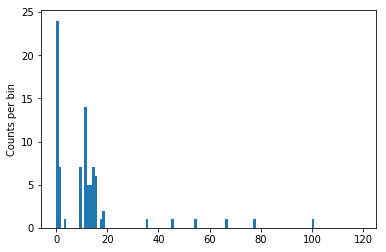

+-----------------------+-----------------------------+
|         Column        | Percentage Missing Data [%] |
+-----------------------+-----------------------------+
|       ANREDE_KZ       |              0              |
|   FINANZ_MINIMALIST   |              0              |
|     FINANZ_SPARER     |              0              |
|    FINANZ_VORSORGER   |              0              |
|     FINANZ_ANLEGER    |              0              |
| FINANZ_UNAUFFAELLIGER |              0              |
|    FINANZ_HAUSBAUER   |              0              |
|       FINANZTYP       |              0              |
|    GREEN_AVANTGARDE   |              0              |
|       SEMIO_SOZ       |              0              |
|       SEMIO_FAM       |              0              |
|       SEMIO_REL       |              0              |
|       SEMIO_MAT       |              0              |
|       SEMIO_VERT      |              0              |
|       SEMIO_LUST      |              0        

1         0
2         1
3         0
4         0
5         0
6         0
7         0
8         1
9         1
10        0
12        0
13        1
15        0
16        0
18        0
19        1
21        0
22        0
23        1
25        0
27        1
28        0
29        1
31        0
32        1
33        0
34        1
36        0
37        0
38        0
         ..
891190    1
891191    0
891192    0
891193    0
891194    1
891195    0
891196    0
891197    1
891198    1
891199    0
891200    0
891201    0
891202    0
891204    0
891205    0
891206    0
891207    1
891208    0
891209    0
891210    0
891211    0
891212    0
891213    1
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Name: GREEN_AVANTGARDE, Length: 774791, dtype: int64

0         0
11        0
14        0
17        0
20        1
24        0
26        0
30        0
35        0
46        0
48        0
53        0
54        0
61        0
62        0
69        0
75        0
76        0
81        0
83        0
90        0
97        0
99        0
103       0
106       0
108       0
109       0
112       0
133       0
137       0
         ..
891049    0
891055    0
891061    0
891062    0
891063    0
891064    0
891069    0
891072    0
891074    0
891092    0
891095    0
891100    0
891117    0
891119    0
891120    0
891130    0
891137    0
891140    0
891154    0
891159    0
891164    0
891169    0
891170    0
891171    0
891172    0
891173    0
891175    0
891185    0
891187    0
891203    0
Name: GREEN_AVANTGARDE, Length: 116430, dtype: int64

CJT_GESAMTTYP


1         5.0
2         3.0
3         2.0
4         5.0
5         2.0
6         5.0
7         3.0
8         3.0
9         4.0
10        1.0
12        6.0
13        5.0
15        4.0
16        1.0
18        6.0
19        3.0
21        3.0
22        4.0
23        3.0
25        3.0
27        4.0
28        2.0
29        1.0
31        6.0
32        4.0
33        4.0
34        2.0
36        2.0
37        2.0
38        6.0
         ... 
891190    1.0
891191    1.0
891192    3.0
891193    3.0
891194    4.0
891195    6.0
891196    6.0
891197    1.0
891198    5.0
891199    3.0
891200    3.0
891201    3.0
891202    5.0
891204    5.0
891205    2.0
891206    4.0
891207    1.0
891208    2.0
891209    5.0
891210    5.0
891211    2.0
891212    1.0
891213    5.0
891214    4.0
891215    6.0
891216    5.0
891217    4.0
891218    4.0
891219    3.0
891220    1.0
Name: CJT_GESAMTTYP, Length: 774791, dtype: float64

0         2.0
11        6.0
14        6.0
17        6.0
20        4.0
24        6.0
26        3.0
30        3.0
35        2.0
46        3.0
48        6.0
53        3.0
54        6.0
61        6.0
62        4.0
69        6.0
75        6.0
76        2.0
81        5.0
83        4.0
90        4.0
97        6.0
99        6.0
103       6.0
106       1.0
108       6.0
109       4.0
112       6.0
133       6.0
137       6.0
         ... 
891049    6.0
891055    6.0
891061    3.0
891062    3.0
891063    2.0
891064    6.0
891069    6.0
891072    6.0
891074    4.0
891092    6.0
891095    6.0
891100    3.0
891117    1.0
891119    3.0
891120    4.0
891130    5.0
891137    4.0
891140    1.0
891154    1.0
891159    1.0
891164    4.0
891169    1.0
891170    4.0
891171    5.0
891172    1.0
891173    1.0
891175    6.0
891185    6.0
891187    6.0
891203    1.0
Name: CJT_GESAMTTYP, Length: 116430, dtype: float64

GFK_URLAUBERTYP


1         10.0
2         10.0
3          1.0
4          5.0
5          1.0
6         12.0
7          9.0
8          3.0
9         12.0
10         8.0
12        10.0
13        12.0
15        12.0
16        10.0
18        11.0
19         8.0
21        11.0
22         4.0
23        12.0
25         1.0
27         8.0
28         1.0
29         5.0
31         1.0
32        10.0
33         5.0
34         5.0
36         5.0
37         5.0
38         1.0
          ... 
891190     3.0
891191     6.0
891192    10.0
891193     4.0
891194     9.0
891195     5.0
891196    12.0
891197     5.0
891198    10.0
891199    11.0
891200    12.0
891201     7.0
891202    10.0
891204    11.0
891205     5.0
891206    12.0
891207     8.0
891208    10.0
891209     9.0
891210     4.0
891211     1.0
891212     4.0
891213     8.0
891214    10.0
891215    12.0
891216    12.0
891217     1.0
891218    10.0
891219     9.0
891220    12.0
Name: GFK_URLAUBERTYP, Length: 774791, dtype: float64

0         10.0
11         5.0
14         5.0
17         5.0
20        11.0
24         5.0
26         2.0
30        11.0
35         7.0
46         1.0
48         5.0
53         9.0
54         5.0
61         1.0
62         9.0
69         5.0
75         5.0
76         1.0
81        11.0
83         8.0
90         1.0
97         5.0
99         5.0
103        5.0
106       12.0
108        5.0
109       11.0
112        5.0
133        5.0
137        5.0
          ... 
891049     5.0
891055     8.0
891061    12.0
891062    12.0
891063     9.0
891064     5.0
891069     4.0
891072     5.0
891074     9.0
891092     5.0
891095     5.0
891100     3.0
891117    12.0
891119    12.0
891120     2.0
891130     2.0
891137    12.0
891140     8.0
891154     5.0
891159    10.0
891164     2.0
891169     2.0
891170    10.0
891171    10.0
891172     9.0
891173     2.0
891175     5.0
891185     5.0
891187     5.0
891203     8.0
Name: GFK_URLAUBERTYP, Length: 116430, dtype: float64

LP_LEBENSPHASE_FEIN


1         21.0
2          3.0
3          NaN
4         32.0
5          8.0
6          2.0
7          5.0
8         10.0
9          4.0
10         6.0
12        23.0
13         3.0
15        12.0
16         NaN
18        10.0
19        20.0
21        10.0
22         1.0
23        20.0
25         NaN
27        25.0
28         5.0
29        13.0
31         2.0
32        18.0
33        31.0
34        13.0
36         5.0
37        38.0
38        10.0
          ... 
891190    13.0
891191     8.0
891192    29.0
891193    16.0
891194    28.0
891195    32.0
891196    25.0
891197    13.0
891198     3.0
891199     2.0
891200    29.0
891201     4.0
891202     2.0
891204    34.0
891205    31.0
891206    10.0
891207    20.0
891208    19.0
891209    29.0
891210     5.0
891211     5.0
891212     6.0
891213    36.0
891214     2.0
891215     2.0
891216     2.0
891217     2.0
891218     NaN
891219    29.0
891220     6.0
Name: LP_LEBENSPHASE_FEIN, Length: 774791, dtype: float64

0         15.0
11         NaN
14         NaN
17         NaN
20        10.0
24         NaN
26        11.0
30         7.0
35        19.0
46         NaN
48         NaN
53        33.0
54         NaN
61        22.0
62         1.0
69         NaN
75         NaN
76        37.0
81         NaN
83        14.0
90         1.0
97         NaN
99         NaN
103        NaN
106        6.0
108        NaN
109        5.0
112        NaN
133        NaN
137        NaN
          ... 
891049     NaN
891055    31.0
891061    11.0
891062     2.0
891063     6.0
891064     NaN
891069     6.0
891072     NaN
891074     1.0
891092     NaN
891095     NaN
891100    31.0
891117    12.0
891119    14.0
891120    10.0
891130    25.0
891137    15.0
891140     6.0
891154    12.0
891159    23.0
891164    28.0
891169     NaN
891170    18.0
891171     7.0
891172    25.0
891173    16.0
891175     NaN
891185     NaN
891187     NaN
891203     NaN
Name: LP_LEBENSPHASE_FEIN, Length: 116430, dtype: float64

LP_LEBENSPHASE_GROB


1          6.0
2          1.0
3          NaN
4         10.0
5          2.0
6          1.0
7          2.0
8          3.0
9          1.0
10         2.0
12         6.0
13         1.0
15         3.0
16         NaN
18         3.0
19         5.0
21         3.0
22         1.0
23         5.0
25         NaN
27         7.0
28         2.0
29         3.0
31         1.0
32         5.0
33        10.0
34         3.0
36         2.0
37        12.0
38         3.0
          ... 
891190     3.0
891191     2.0
891192     9.0
891193     4.0
891194     8.0
891195    10.0
891196     7.0
891197     3.0
891198     1.0
891199     1.0
891200     9.0
891201     1.0
891202     1.0
891204    11.0
891205    10.0
891206     3.0
891207     5.0
891208     5.0
891209     9.0
891210     2.0
891211     2.0
891212     2.0
891213    12.0
891214     1.0
891215     1.0
891216     1.0
891217     1.0
891218     NaN
891219     9.0
891220     2.0
Name: LP_LEBENSPHASE_GROB, Length: 774791, dtype: float64

0          4.0
11         NaN
14         NaN
17         NaN
20         3.0
24         NaN
26         3.0
30         2.0
35         5.0
46         NaN
48         NaN
53        11.0
54         NaN
61         6.0
62         1.0
69         NaN
75         NaN
76        12.0
81         NaN
83         4.0
90         1.0
97         NaN
99         NaN
103        NaN
106        2.0
108        NaN
109        2.0
112        NaN
133        NaN
137        NaN
          ... 
891049     NaN
891055    10.0
891061     3.0
891062     1.0
891063     2.0
891064     NaN
891069     2.0
891072     NaN
891074     1.0
891092     NaN
891095     NaN
891100    10.0
891117     3.0
891119     4.0
891120     3.0
891130     7.0
891137     4.0
891140     2.0
891154     3.0
891159     6.0
891164     8.0
891169     NaN
891170     5.0
891171     2.0
891172     7.0
891173     4.0
891175     NaN
891185     NaN
891187     NaN
891203     NaN
Name: LP_LEBENSPHASE_GROB, Length: 116430, dtype: float64

LP_FAMILIE_FEIN


1          5.0
2          1.0
3          NaN
4         10.0
5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
10         1.0
12         5.0
13         1.0
15         1.0
16         NaN
18         1.0
19         2.0
21         1.0
22         1.0
23         2.0
25         NaN
27         7.0
28         1.0
29         1.0
31         1.0
32         2.0
33        11.0
34         1.0
36         1.0
37        10.0
38         1.0
          ... 
891190     1.0
891191     1.0
891192    10.0
891193     2.0
891194     7.0
891195    10.0
891196     7.0
891197     1.0
891198     1.0
891199     1.0
891200    10.0
891201     1.0
891202     1.0
891204    11.0
891205    10.0
891206     1.0
891207     2.0
891208     2.0
891209    10.0
891210     1.0
891211     1.0
891212     1.0
891213    11.0
891214     1.0
891215     1.0
891216     1.0
891217     1.0
891218     NaN
891219     9.0
891220     1.0
Name: LP_FAMILIE_FEIN, Length: 774791, dtype: float64

0          2.0
11         NaN
14         NaN
17         NaN
20         1.0
24         NaN
26         1.0
30         1.0
35         2.0
46         1.0
48         NaN
53        10.0
54         NaN
61         3.0
62         1.0
69         NaN
75         NaN
76        10.0
81         1.0
83         2.0
90         1.0
97         NaN
99         NaN
103        NaN
106        1.0
108        NaN
109        1.0
112        NaN
133        NaN
137        NaN
          ... 
891049     NaN
891055    10.0
891061     1.0
891062     1.0
891063     1.0
891064     NaN
891069     1.0
891072     NaN
891074     1.0
891092     NaN
891095     NaN
891100    10.0
891117     1.0
891119     2.0
891120     1.0
891130     6.0
891137     2.0
891140     1.0
891154     1.0
891159     3.0
891164     6.0
891169     NaN
891170     2.0
891171     1.0
891172     7.0
891173     2.0
891175     NaN
891185     NaN
891187     NaN
891203     NaN
Name: LP_FAMILIE_FEIN, Length: 116430, dtype: float64

+-------------+-------+
|     Type    | Count |
+-------------+-------+
|   interval  |   1   |
|    mixed    |   7   |
|   numeric   |   7   |
| categorical |   21  |
|   ordinal   |   49  |
+-------------+-------+
+-----------------------+----------------+
|     Attribute Name    | Attribute Type |
+-----------------------+----------------+
|        AGER_TYP       |  categorical   |
|       ANREDE_KZ       |  categorical   |
|    CAMEO_DEUG_2015    |  categorical   |
|     CAMEO_DEU_2015    |  categorical   |
|     CJT_GESAMTTYP     |  categorical   |
|       FINANZTYP       |  categorical   |
|      GEBAEUDETYP      |  categorical   |
|    GFK_URLAUBERTYP    |  categorical   |
|    GREEN_AVANTGARDE   |  categorical   |
|      KK_KUNDENTYP     |  categorical   |
|    LP_FAMILIE_FEIN    |  categorical   |
|    LP_FAMILIE_GROB    |  categorical   |
|     LP_STATUS_FEIN    |  categorical   |
|     LP_STATUS_GROB    |  categorical   |
|    NATIONALITAET_KZ   |  categorical   |
|      OST

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0,1,14.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,1,15.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,8.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0,1,3.0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,0,1,10.0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1.0,4.0,4.0,2.0,5.0,2.0,0,1,8.0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,0,1,11.0,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,0,1,15.0,1
10,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,3.0,0
19,3.0,1,5,2,3,1,3,1,1,3.0,...,2.0,5.0,4.0,4.0,6.0,3.0,0,1,9.0,1


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,0,1,14.0,0,1,5
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,1,15.0,1,4,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,1,8.0,0,3,4
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,1,3.0,0,4,5
6,2.0,2,1,5,1,5,4,3,0,2.0,...,5.0,4.0,6.0,3.0,0,1,10.0,0,2,2
7,1.0,1,3,3,4,1,3,2,0,1.0,...,4.0,2.0,5.0,2.0,0,1,8.0,0,4,1
8,3.0,1,4,4,2,4,2,2,1,3.0,...,3.0,2.0,4.0,3.0,0,1,11.0,1,3,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,3.0,2.0,3.0,1.0,0,1,15.0,1,5,1
10,3.0,2,2,2,5,3,1,5,0,2.0,...,3.0,4.0,6.0,5.0,0,1,3.0,0,1,5
19,3.0,1,5,2,3,1,3,1,1,3.0,...,4.0,4.0,6.0,3.0,0,1,9.0,1,4,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 69 columns):
ALTERSKATEGORIE_GROB              623209 non-null float64
ANREDE_KZ                         623209 non-null int64
FINANZ_MINIMALIST                 623209 non-null int64
FINANZ_SPARER                     623209 non-null int64
FINANZ_VORSORGER                  623209 non-null int64
FINANZ_ANLEGER                    623209 non-null int64
FINANZ_UNAUFFAELLIGER             623209 non-null int64
FINANZ_HAUSBAUER                  623209 non-null int64
GREEN_AVANTGARDE                  623209 non-null int64
HEALTH_TYP                        623209 non-null float64
LP_LEBENSPHASE_FEIN               623209 non-null float64
LP_LEBENSPHASE_GROB               623209 non-null float64
RETOURTYP_BK_S                    623209 non-null float64
SEMIO_SOZ                         623209 non-null int64
SEMIO_FAM                         623209 non-null int64
SEMIO_REL                         62320

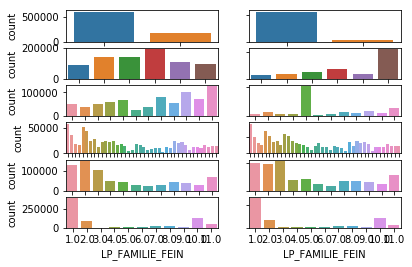

In [42]:
# testing the cleaning function with the general population data
re_engineered_with_cleaning_funk = clean_data(azdias_df_clustering_copy, 20) 
re_engineered_with_cleaning_funk.info()

In [43]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(re_engineered_with_cleaning_funk)
print(np.shape(scaled_data))


(623209, 69)


### Discussion 2.1: Apply Feature Scaling

Feature scaling has been applied to the data in order to bring each of the features in the data set to a standardized/normalized form. This means that the values for each feature in the data set will not be extremely high or extremely low when compared to the values of the other features in the data set. The scaling therefore enhances the performance of the algorithms that follwos.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.
azdias_pca = PCA(n_components=None)

In [45]:
# Investigate the variance accounted for by each principal component.
azdias_pca.fit_transform(scaled_data) 

array([[  3.27845763e+00,  -2.98128023e+00,  -3.05439645e+00, ...,
         -1.65450481e-01,   1.26158401e-13,  -1.35810288e-14],
       [ -7.97649204e-01,   1.69961552e-01,  -3.11241041e+00, ...,
          5.41062435e-02,  -5.75353066e-13,   1.79013574e-14],
       [  5.54473909e-02,   6.64474669e-02,   3.22843061e+00, ...,
          3.61939585e-02,   4.20899086e-13,  -9.20446862e-16],
       ..., 
       [  3.46431993e+00,  -2.03799592e+00,  -3.68623152e+00, ...,
          6.69467473e-02,   4.50142106e-15,   1.17409109e-16],
       [  5.55130947e+00,  -3.58725199e+00,   2.16075466e+00, ...,
         -3.03302794e-02,  -1.08314446e-14,   5.17785805e-17],
       [ -5.90570250e-01,   1.02671406e+00,   2.84310991e+00, ...,
          6.10257380e-02,   1.09935312e-15,  -2.06216383e-16]])

In [46]:
np.shape(azdias_pca.explained_variance_ratio_)
-np.sort(-azdias_pca.explained_variance_ratio_) #sorts the array in descending order

array([  1.75724112e-01,   1.29410495e-01,   8.95814446e-02,
         5.65664085e-02,   4.31950410e-02,   3.38622712e-02,
         3.12079700e-02,   2.77102019e-02,   2.42094550e-02,
         2.22594367e-02,   1.97576377e-02,   1.86267340e-02,
         1.76040085e-02,   1.59776684e-02,   1.51570235e-02,
         1.44900058e-02,   1.41821462e-02,   1.34335449e-02,
         1.25652306e-02,   1.22751455e-02,   1.18580220e-02,
         1.11514882e-02,   1.07748926e-02,   1.03103704e-02,
         1.00415540e-02,   9.21528120e-03,   8.17833286e-03,
         7.43311372e-03,   7.24087334e-03,   7.10575102e-03,
         6.75565406e-03,   6.57716443e-03,   6.15845209e-03,
         5.87397067e-03,   5.70573359e-03,   5.56256047e-03,
         5.46455657e-03,   4.96270473e-03,   4.32063703e-03,
         4.10750555e-03,   3.95231590e-03,   3.84869381e-03,
         3.66766974e-03,   3.56883163e-03,   3.43632547e-03,
         3.30265390e-03,   3.25715767e-03,   3.09394954e-03,
         2.99630226e-03,

In [47]:
def get_list_pc_strings(length):
    idx = 1
    pc_columns = list()
    token = 'PC-'
    while idx <= length:
        col_name = token + str(idx)
        pc_columns.append(col_name)
        idx = idx + 1
    return pc_columns

In [48]:
pc_columns = get_list_pc_strings(len(azdias_pca.explained_variance_ratio_))
df_scree = pd.DataFrame({'var':azdias_pca.explained_variance_ratio_,
             'PC':pc_columns})
df_scree = df_scree[:35]

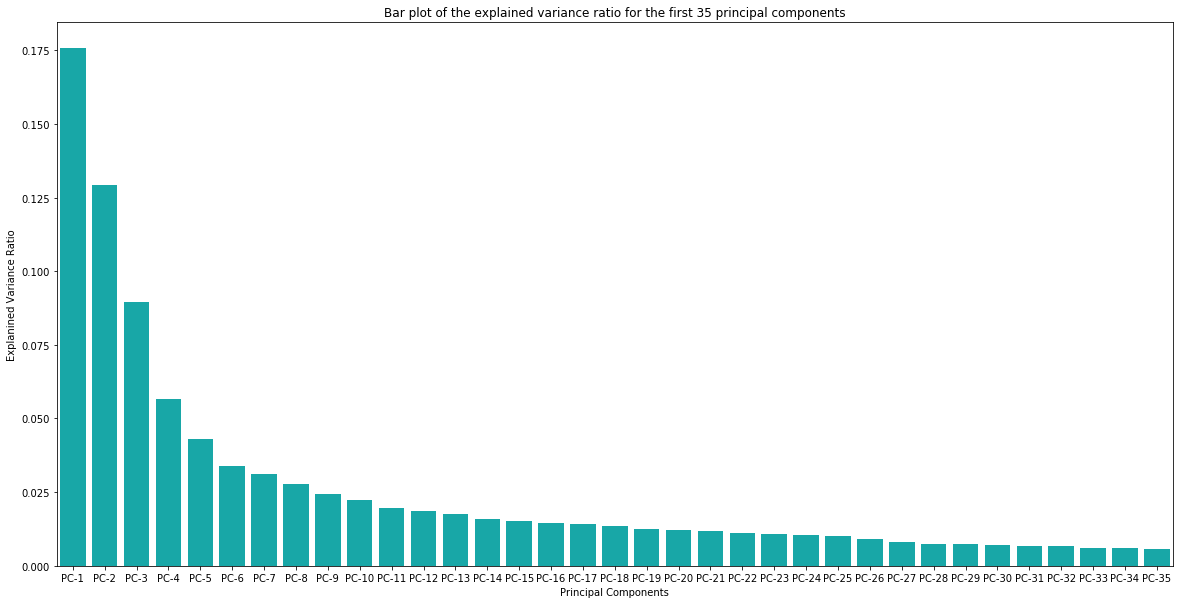

In [49]:
plt.figure(figsize=(20,10))
sns.barplot(x='PC',y="var", data=df_scree, color="c");
plt.title('Bar plot of the explained variance ratio for the first 35 principal components')
plt.ylabel('Explanined Variance Ratio', fontsize=10)
plt.xlabel('Principal Components', fontsize=10)
plt.show()

numpy.ndarray

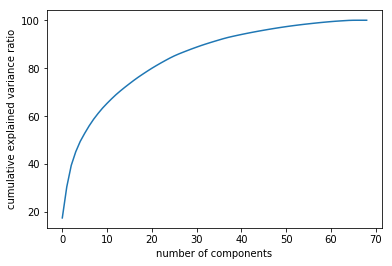

In [50]:
cummulative_sum = 100.0 * np.cumsum(azdias_pca.explained_variance_ratio_)
plt.plot(cummulative_sum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio');
type(cummulative_sum)

In [51]:
def get_number_of_pcs_to_use(cummulative_sum, limit):
    number_of_pcs = 0
    for cum_sum in np.nditer(cummulative_sum):
        if cum_sum > limit:
            number_of_pcs = number_of_pcs + 1
            return number_of_pcs
        number_of_pcs = number_of_pcs + 1
    return None
    
number_of_pcs = get_number_of_pcs_to_use(cummulative_sum, 97.0)
print(number_of_pcs)

50


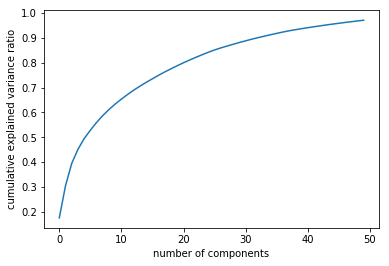

(623209, 69)
[ 0.17572411  0.30513461  0.39471605  0.45128246  0.4944775   0.52833977
  0.55954774  0.58725794  0.6114674   0.63372684  0.65348447  0.67211121
  0.68971522  0.70569288  0.72084991  0.73533991  0.74952206  0.7629556
  0.77552083  0.78779598  0.799654    0.81080549  0.82158038  0.83189075
  0.84193231  0.85114759  0.85932592  0.86675902  0.87399988  0.88110563
  0.88786128  0.89443844  0.90059683  0.90647077  0.91217648  0.91773902
  0.92320337  0.92816607  0.93248667  0.93659333  0.94054556  0.94439398
  0.94806122  0.95162975  0.955064    0.95836431  0.96161822  0.9647107
  0.96770669  0.97058027]


In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
azdias_pca_reduced_dim = PCA(n_components=number_of_pcs)
azdias_pca_reduced_dim_result = azdias_pca_reduced_dim.fit_transform(scaled_data) 
plt.plot(np.cumsum(azdias_pca_reduced_dim.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio');
plt.show()
print(scaled_data.shape)
print(azdias_pca_reduced_dim.explained_variance_ratio_.cumsum())

### Discussion 2.2: Perform Dimensionality Reduction
PCA was first performed expreimentally in order to access the explained variance relative to the features in the dataset. Based on the explained variance and the rule of thumb for more 70% cummulative explained variance, a limit of 97% cummulative explained variance was set. Using this limit resulted in the selection of PCA components equal to 50.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
def process_principal_components(model):
    pc_rows = get_list_pc_strings(len(azdias_pca_reduced_dim.explained_variance_ratio_))
    df_for_pcs = pd.DataFrame(model.components_,columns=re_engineered.columns, index=pc_rows)
    df_for_pcs.values.sort()
    return df_for_pcs

df_for_pcs = process_principal_components(azdias_pca_reduced_dim)
print(df_for_pcs.shape)
print(df_for_pcs)

(50, 69)
       ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
PC-1              -0.232196  -0.218913          -0.217223      -0.207527   
PC-2              -0.266181  -0.256677          -0.242169      -0.240114   
PC-3              -0.368397  -0.338643          -0.312611      -0.270721   
PC-4              -0.266118  -0.233055          -0.218624      -0.208800   
PC-5              -0.333620  -0.277007          -0.266756      -0.259123   
PC-6              -0.312045  -0.217832          -0.174640      -0.174640   
PC-7              -0.249647  -0.242149          -0.238492      -0.238062   
PC-8              -0.304820  -0.285845          -0.277772      -0.255382   
PC-9              -0.312835  -0.296448          -0.293931      -0.251504   
PC-10             -0.301351  -0.268657          -0.176383      -0.161105   
PC-11             -0.482147  -0.297478          -0.279045      -0.200599   
PC-12             -0.238295  -0.223928          -0.216133      -0.192453   
PC-

In [54]:
def get_principal_component(df, row_index):
    df.values.sort()
    df = df.iloc[:,::-1]
    pc = df.iloc[row_index]
    return pc

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
first_pc = get_principal_component(df_for_pcs, 0)
display(first_pc)

CAMEO_INTL_2015_LIFE_STAGE        0.216802
CAMEO_INTL_2015_WEALTH            0.211727
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.208907
PRAEGENDE_JUGENDJAHRE_DECADE      0.195154
OST_WEST_KZ_W                     0.190981
OST_WEST_KZ_O                     0.187935
RELAT_AB                          0.183861
ORTSGR_KLS9                       0.152719
ARBEIT                            0.147326
PLZ8_GBZ                          0.141794
PLZ8_HHZ                          0.140313
PLZ8_BAUMAX                       0.130859
PLZ8_ANTG4                        0.130809
PLZ8_ANTG3                        0.130117
PLZ8_ANTG2                        0.125381
PLZ8_ANTG1                        0.099688
KBA13_ANZAHL_PKW                  0.096816
REGIOTYP                          0.088243
ONLINE_AFFINITAET                 0.084682
MOBI_REGIO                        0.083006
KKK                               0.076852
GEBAEUDETYP_RASTER                0.073453
INNENSTADT                        0.068096
EWDICHTE   

In [56]:
#Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_pc = get_principal_component(df_for_pcs, 1)
display(second_pc)

CAMEO_INTL_2015_LIFE_STAGE        0.264056
CAMEO_INTL_2015_WEALTH            0.234524
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.231021
PRAEGENDE_JUGENDJAHRE_DECADE      0.182583
OST_WEST_KZ_W                     0.164970
OST_WEST_KZ_O                     0.119427
RELAT_AB                          0.118180
ORTSGR_KLS9                       0.105645
ARBEIT                            0.105102
PLZ8_GBZ                          0.085416
PLZ8_HHZ                          0.082803
PLZ8_BAUMAX                       0.080377
PLZ8_ANTG4                        0.080354
PLZ8_ANTG3                        0.079498
PLZ8_ANTG2                        0.076331
PLZ8_ANTG1                        0.074895
KBA13_ANZAHL_PKW                  0.064899
REGIOTYP                          0.061041
ONLINE_AFFINITAET                 0.060722
MOBI_REGIO                        0.059552
KKK                               0.058055
GEBAEUDETYP_RASTER                0.056193
INNENSTADT                        0.054022
EWDICHTE   

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pc = get_principal_component(df_for_pcs, 2)
display(third_pc)

CAMEO_INTL_2015_LIFE_STAGE        0.349488
CAMEO_INTL_2015_WEALTH            0.263661
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.251294
PRAEGENDE_JUGENDJAHRE_DECADE      0.232218
OST_WEST_KZ_W                     0.162552
OST_WEST_KZ_O                     0.113901
RELAT_AB                          0.097339
ORTSGR_KLS9                       0.089489
ARBEIT                            0.081812
PLZ8_GBZ                          0.077023
PLZ8_HHZ                          0.073148
PLZ8_BAUMAX                       0.055935
PLZ8_ANTG4                        0.055935
PLZ8_ANTG3                        0.048534
PLZ8_ANTG2                        0.044601
PLZ8_ANTG1                        0.044366
KBA13_ANZAHL_PKW                  0.043340
REGIOTYP                          0.041455
ONLINE_AFFINITAET                 0.040073
MOBI_REGIO                        0.036334
KKK                               0.029390
GEBAEUDETYP_RASTER                0.027411
INNENSTADT                        0.025786
EWDICHTE   

### Discussion 2.3: Interpret Principal Components

Based on the first three principal components and the bar plot of the explained variance shown above we have the followings:
The first three principal components (PCA-1, PCA-2 and PCA-3) contained more than 35% of the information for the features in the dataset. The first principal component has more positive weights for CAMEO_INTL_2015_LIFE_STAGE, CAMEO_INTL_2015_WEALTH PRAEGENDE_JUGENDJAHRE_MOVEMENT; these three features amplieifes PCA-1 while the following features: FINANZ_HAUSBAUER, FINANZ_UNAUFFAELLIGER, FINANZ_ANLEGER, FINANZ_VORSORGER, FINANZ_SPARER, FINANZ_MINIMALIST, ANREDE_KZ,                   ALTERSKATEGORIE_GROB tend to shrink PCA-1.
The same trend is seeing in PCA-2 and PCA-3 respectively.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
def get_optimum_number_of_clusters(df):
    # Create and fit a range of models
    km_list = list()
    
    for clust in range(1,26):
        km = KMeans(n_clusters = clust, init = 'k-means++', random_state = 42)
        km = km.fit(df)
        km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))
    return km_list

def plot_data(data_list):
    plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))
    
    ax = plot_data.plot(marker='o',ls='-')
    ax.set_xticks(range(0,21,2))
    ax.set_xlim(0,20)
    ax.set(xlabel='Cluster', ylabel='Inertia');
    plt.title('Elbow Method For Optimal clusters')
    plt.show()

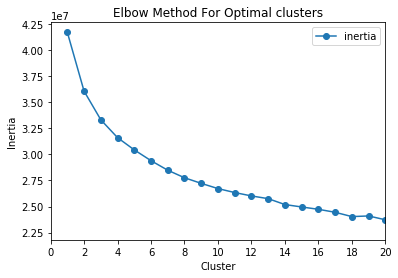

In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
km_list  = get_optimum_number_of_clusters(azdias_pca_reduced_dim_result)
plot_data(km_list)

In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
clust = 5
km = KMeans(n_clusters = clust, init = 'k-means++', random_state = 42)
km = km.fit(azdias_pca_reduced_dim_result)

In [61]:
re_engineered_with_cleaning_funk_copy = re_engineered_with_cleaning_funk.copy()
df_pca_kmeans = pd.concat([re_engineered_with_cleaning_funk_copy.reset_index(drop = True), pd.DataFrame(azdias_pca_reduced_dim_result)], axis = 1)
df_pca_kmeans.columns.values[-50: ] = get_list_pc_strings(len(azdias_pca_reduced_dim.explained_variance_ratio_))
df_pca_kmeans['Segment K-means PCA'] = km.labels_
df_pca_kmeans

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PC-42,PC-43,PC-44,PC-45,PC-46,PC-47,PC-48,PC-49,PC-50,Segment K-means PCA
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0.019574,-0.289594,-0.332409,-0.548981,-0.159381,-0.008383,0.160377,0.742541,-0.268128,3
1,3.0,2,1,4,1,2,3,5,1,3.0,...,-0.104953,0.212136,-0.408254,0.352758,0.263801,-0.091362,-0.215064,-0.721402,0.084772,4
2,3.0,1,4,3,4,1,3,2,0,3.0,...,0.160558,-0.062974,0.685580,0.234949,1.099102,-0.195173,-0.420367,-0.301643,-0.413962,1
3,1.0,2,3,1,5,2,2,5,0,3.0,...,0.913260,-0.682839,-0.091111,0.108005,0.272477,-0.408841,-0.502928,0.764512,-0.400200,0
4,2.0,2,1,5,1,5,4,3,0,2.0,...,0.413426,0.818240,0.266625,0.440815,0.226671,0.469978,0.427297,0.073681,0.193730,0
5,1.0,1,3,3,4,1,3,2,0,1.0,...,-0.124383,-0.265105,0.342592,0.618741,0.286376,0.379438,-0.367642,0.380805,0.154523,1
6,3.0,1,4,4,2,4,2,2,1,3.0,...,-1.074475,-1.091348,0.145697,0.233523,-0.611188,1.697950,-0.794882,-0.147287,-0.470894,1
7,3.0,2,2,4,2,3,5,4,1,2.0,...,0.679302,-0.104986,-0.659592,-0.491089,-0.080890,1.075021,0.771148,-0.159157,-0.248048,4
8,3.0,2,2,2,5,3,1,5,0,2.0,...,0.376066,0.009454,-0.076713,0.268493,0.499888,-0.505022,-0.064030,-0.507169,0.596570,2
9,3.0,1,5,2,3,1,3,1,1,3.0,...,0.475816,-0.371014,-0.338822,0.193746,-0.698460,-0.474954,0.423242,-0.877740,-0.313506,1


### Discussion 3.1: Apply Clustering to General Population
Using the  Within Cluster Sum of Squares (WCSS) available as the inertial_ attribute available kmeans clustering from sklearn, an approximate value for the optimal value of the number of clusters to bused was determined through the elbow method as shown in the plot above. This number was determined to somewhere around 5.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
customers_file_path = current_wd + '/Udacity_CUSTOMERS_Subset.csv'
customers_df = read_csv_file(customers_file_path)
customers_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [63]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1.0,3.0,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2.0,4.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1.0,4.0,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2.0,4.0,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1.0,3.0,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


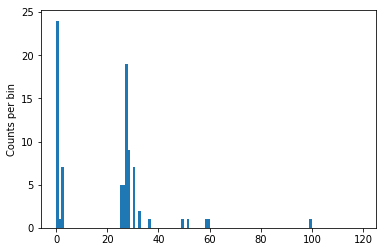

+-----------------------+-----------------------------+
|         Column        | Percentage Missing Data [%] |
+-----------------------+-----------------------------+
|       ANREDE_KZ       |              0              |
|   FINANZ_MINIMALIST   |              0              |
|     FINANZ_SPARER     |              0              |
|    FINANZ_VORSORGER   |              0              |
|     FINANZ_ANLEGER    |              0              |
| FINANZ_UNAUFFAELLIGER |              0              |
|    FINANZ_HAUSBAUER   |              0              |
|       FINANZTYP       |              0              |
|    GREEN_AVANTGARDE   |              0              |
|       SEMIO_SOZ       |              0              |
|       SEMIO_FAM       |              0              |
|       SEMIO_REL       |              0              |
|       SEMIO_MAT       |              0              |
|       SEMIO_VERT      |              0              |
|       SEMIO_LUST      |              0        

0         0
2         1
3         0
4         0
5         0
6         0
7         0
8         1
9         1
11        0
12        0
13        1
14        0
15        0
16        0
17        0
18        0
19        1
20        1
21        0
22        0
23        1
24        0
25        0
26        0
27        1
28        0
29        1
30        0
31        0
         ..
191621    0
191622    0
191623    1
191624    1
191625    0
191626    0
191627    0
191628    1
191629    0
191630    0
191631    0
191632    1
191633    0
191634    0
191635    0
191636    0
191637    0
191638    1
191639    0
191640    1
191641    0
191642    0
191643    0
191644    1
191645    0
191646    0
191647    1
191649    0
191650    1
191651    0
Name: GREEN_AVANTGARDE, Length: 136208, dtype: int64

1         0
10        0
36        0
37        0
38        0
39        1
40        0
43        0
44        0
46        0
48        0
51        1
53        0
54        0
55        0
56        1
58        1
59        0
60        0
62        0
67        0
68        0
69        0
71        0
72        0
84        0
85        0
87        1
89        0
90        0
         ..
191421    0
191423    1
191425    1
191429    1
191436    0
191438    1
191440    0
191441    0
191442    0
191444    0
191445    0
191451    0
191452    0
191459    0
191465    0
191467    1
191477    0
191481    1
191485    0
191504    0
191532    0
191535    0
191537    0
191540    0
191553    0
191565    0
191575    0
191597    0
191605    1
191648    1
Name: GREEN_AVANTGARDE, Length: 55444, dtype: int64

CJT_GESAMTTYP


0         2.0
2         3.0
3         2.0
4         5.0
5         2.0
6         5.0
7         3.0
8         3.0
9         4.0
11        6.0
12        6.0
13        5.0
14        6.0
15        4.0
16        1.0
17        6.0
18        6.0
19        3.0
20        4.0
21        3.0
22        4.0
23        3.0
24        6.0
25        3.0
26        3.0
27        4.0
28        2.0
29        1.0
30        3.0
31        6.0
         ... 
191621    4.0
191622    2.0
191623    2.0
191624    4.0
191625    5.0
191626    6.0
191627    6.0
191628    3.0
191629    3.0
191630    1.0
191631    3.0
191632    2.0
191633    2.0
191634    3.0
191635    3.0
191636    4.0
191637    2.0
191638    3.0
191639    2.0
191640    5.0
191641    3.0
191642    1.0
191643    2.0
191644    6.0
191645    3.0
191646    3.0
191647    5.0
191649    4.0
191650    3.0
191651    3.0
Name: CJT_GESAMTTYP, Length: 136208, dtype: float64

1         5.0
10        1.0
36        2.0
37        2.0
38        6.0
39        4.0
40        1.0
43        4.0
44        4.0
46        3.0
48        6.0
51        5.0
53        3.0
54        6.0
55        5.0
56        2.0
58        4.0
59        4.0
60        6.0
62        4.0
67        3.0
68        5.0
69        6.0
71        1.0
72        1.0
84        4.0
85        2.0
87        2.0
89        3.0
90        4.0
         ... 
191421    6.0
191423    5.0
191425    4.0
191429    6.0
191436    6.0
191438    4.0
191440    5.0
191441    5.0
191442    4.0
191444    6.0
191445    3.0
191451    6.0
191452    4.0
191459    6.0
191465    5.0
191467    5.0
191477    6.0
191481    3.0
191485    4.0
191504    2.0
191532    2.0
191535    2.0
191537    1.0
191540    4.0
191553    5.0
191565    6.0
191575    NaN
191597    4.0
191605    2.0
191648    3.0
Name: CJT_GESAMTTYP, Length: 55444, dtype: float64

GFK_URLAUBERTYP


0         10.0
2         10.0
3          1.0
4          5.0
5          1.0
6         12.0
7          9.0
8          3.0
9         12.0
11         5.0
12        10.0
13        12.0
14         5.0
15        12.0
16        10.0
17         5.0
18        11.0
19         8.0
20        11.0
21        11.0
22         4.0
23        12.0
24         5.0
25         1.0
26         2.0
27         8.0
28         1.0
29         5.0
30        11.0
31         1.0
          ... 
191621    10.0
191622    11.0
191623    10.0
191624    10.0
191625     9.0
191626     7.0
191627     3.0
191628     3.0
191629    12.0
191630    12.0
191631     3.0
191632     1.0
191633    11.0
191634    12.0
191635     1.0
191636    12.0
191637     8.0
191638     3.0
191639    12.0
191640     9.0
191641    11.0
191642    11.0
191643     7.0
191644     5.0
191645    10.0
191646     9.0
191647     5.0
191649     7.0
191650     7.0
191651     8.0
Name: GFK_URLAUBERTYP, Length: 136208, dtype: float64

1         10.0
10         8.0
36         5.0
37         5.0
38         1.0
39        10.0
40         4.0
43        10.0
44        11.0
46         1.0
48         5.0
51        12.0
53         9.0
54         5.0
55         3.0
56         3.0
58         3.0
59        10.0
60         3.0
62         9.0
67         1.0
68         6.0
69         5.0
71        12.0
72         4.0
84         4.0
85         4.0
87        10.0
89         1.0
90         1.0
          ... 
191421    12.0
191423    10.0
191425     9.0
191429    11.0
191436     4.0
191438    10.0
191440     2.0
191441     8.0
191442     5.0
191444    10.0
191445    10.0
191451     8.0
191452     8.0
191459     9.0
191465     3.0
191467     8.0
191477     9.0
191481     8.0
191485    11.0
191504     7.0
191532     7.0
191535     6.0
191537    10.0
191540     3.0
191553     8.0
191565    11.0
191575     NaN
191597     9.0
191605     6.0
191648     7.0
Name: GFK_URLAUBERTYP, Length: 55444, dtype: float64

LP_LEBENSPHASE_FEIN


0         15.0
2          3.0
3          NaN
4         32.0
5          8.0
6          2.0
7          5.0
8         10.0
9          4.0
11         NaN
12        23.0
13         3.0
14         NaN
15        12.0
16         NaN
17         NaN
18        10.0
19        20.0
20        10.0
21        10.0
22         1.0
23        20.0
24         NaN
25         NaN
26        11.0
27        25.0
28         5.0
29        13.0
30         7.0
31         2.0
          ... 
191621    34.0
191622     8.0
191623     NaN
191624    34.0
191625    27.0
191626     1.0
191627    22.0
191628     3.0
191629     4.0
191630     6.0
191631     5.0
191632    35.0
191633     1.0
191634     7.0
191635     5.0
191636    18.0
191637     9.0
191638     4.0
191639     8.0
191640    33.0
191641    37.0
191642    37.0
191643    12.0
191644    36.0
191645     6.0
191646    11.0
191647    30.0
191649    30.0
191650    13.0
191651    31.0
Name: LP_LEBENSPHASE_FEIN, Length: 136208, dtype: float64

1         21.0
10         6.0
36         5.0
37        38.0
38        10.0
39        35.0
40         8.0
43         1.0
44         7.0
46         NaN
48         NaN
51        22.0
53        33.0
54         NaN
55         5.0
56        35.0
58        18.0
59         2.0
60         7.0
62         1.0
67        38.0
68        38.0
69         NaN
71        22.0
72         6.0
84         5.0
85        12.0
87        39.0
89         1.0
90         1.0
          ... 
191421    10.0
191423    13.0
191425    28.0
191429    39.0
191436     5.0
191438    23.0
191440    19.0
191441     NaN
191442     7.0
191444     1.0
191445     5.0
191451     5.0
191452    32.0
191459    24.0
191465    31.0
191467     7.0
191477    24.0
191481    28.0
191485     6.0
191504    16.0
191532    36.0
191535    13.0
191537    11.0
191540    29.0
191553    29.0
191565     3.0
191575     NaN
191597     2.0
191605     NaN
191648    20.0
Name: LP_LEBENSPHASE_FEIN, Length: 55444, dtype: float64

LP_LEBENSPHASE_GROB


0          4.0
2          1.0
3          NaN
4         10.0
5          2.0
6          1.0
7          2.0
8          3.0
9          1.0
11         NaN
12         6.0
13         1.0
14         NaN
15         3.0
16         NaN
17         NaN
18         3.0
19         5.0
20         3.0
21         3.0
22         1.0
23         5.0
24         NaN
25         NaN
26         3.0
27         7.0
28         2.0
29         3.0
30         2.0
31         1.0
          ... 
191621    11.0
191622     2.0
191623     NaN
191624    11.0
191625     8.0
191626     1.0
191627     6.0
191628     1.0
191629     1.0
191630     2.0
191631     2.0
191632    11.0
191633     1.0
191634     2.0
191635     2.0
191636     5.0
191637     3.0
191638     1.0
191639     2.0
191640    11.0
191641    12.0
191642    12.0
191643     3.0
191644    12.0
191645     2.0
191646     3.0
191647     9.0
191649     9.0
191650     3.0
191651    10.0
Name: LP_LEBENSPHASE_GROB, Length: 136208, dtype: float64

1          6.0
10         2.0
36         2.0
37        12.0
38         3.0
39        11.0
40         2.0
43         1.0
44         2.0
46         NaN
48         NaN
51         6.0
53        11.0
54         NaN
55         2.0
56        11.0
58         5.0
59         1.0
60         2.0
62         1.0
67        12.0
68        12.0
69         NaN
71         6.0
72         2.0
84         2.0
85         3.0
87        12.0
89         1.0
90         1.0
          ... 
191421     3.0
191423     3.0
191425     8.0
191429    12.0
191436     2.0
191438     6.0
191440     5.0
191441     NaN
191442     2.0
191444     1.0
191445     2.0
191451     2.0
191452    10.0
191459     7.0
191465    10.0
191467     2.0
191477     7.0
191481     8.0
191485     2.0
191504     4.0
191532    12.0
191535     3.0
191537     3.0
191540     9.0
191553     9.0
191565     1.0
191575     NaN
191597     1.0
191605     NaN
191648     5.0
Name: LP_LEBENSPHASE_GROB, Length: 55444, dtype: float64

LP_FAMILIE_FEIN


0          2.0
2          1.0
3          NaN
4         10.0
5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
11         NaN
12         5.0
13         1.0
14         NaN
15         1.0
16         NaN
17         NaN
18         1.0
19         2.0
20         1.0
21         1.0
22         1.0
23         2.0
24         NaN
25         NaN
26         1.0
27         7.0
28         1.0
29         1.0
30         1.0
31         1.0
          ... 
191621    11.0
191622     1.0
191623     NaN
191624     9.0
191625     7.0
191626     1.0
191627     5.0
191628     1.0
191629     1.0
191630     1.0
191631     1.0
191632    10.0
191633     1.0
191634     1.0
191635     1.0
191636     2.0
191637     1.0
191638     1.0
191639     1.0
191640    11.0
191641    10.0
191642    10.0
191643     1.0
191644    11.0
191645     1.0
191646     1.0
191647    10.0
191649    10.0
191650     1.0
191651    10.0
Name: LP_FAMILIE_FEIN, Length: 136208, dtype: float64

1          5.0
10         1.0
36         1.0
37        10.0
38         1.0
39        11.0
40         1.0
43         1.0
44         1.0
46         1.0
48         NaN
51         5.0
53        10.0
54         NaN
55         1.0
56        10.0
58         2.0
59         1.0
60         1.0
62         1.0
67        10.0
68        10.0
69         NaN
71         4.0
72         1.0
84         1.0
85         1.0
87        11.0
89         1.0
90         1.0
          ... 
191421     1.0
191423     1.0
191425     6.0
191429    10.0
191436     1.0
191438     5.0
191440     2.0
191441     NaN
191442     1.0
191444     1.0
191445     1.0
191451     1.0
191452    10.0
191459     7.0
191465    10.0
191467     1.0
191477     6.0
191481     8.0
191485     1.0
191504     2.0
191532    11.0
191535     1.0
191537     1.0
191540    10.0
191553    11.0
191565     1.0
191575     NaN
191597     1.0
191605     NaN
191648     2.0
Name: LP_FAMILIE_FEIN, Length: 55444, dtype: float64

+-------------+-------+
|     Type    | Count |
+-------------+-------+
|   interval  |   1   |
|    mixed    |   7   |
|   numeric   |   7   |
| categorical |   21  |
|   ordinal   |   49  |
+-------------+-------+
+-----------------------+----------------+
|     Attribute Name    | Attribute Type |
+-----------------------+----------------+
|        AGER_TYP       |  categorical   |
|       ANREDE_KZ       |  categorical   |
|    CAMEO_DEUG_2015    |  categorical   |
|     CAMEO_DEU_2015    |  categorical   |
|     CJT_GESAMTTYP     |  categorical   |
|       FINANZTYP       |  categorical   |
|      GEBAEUDETYP      |  categorical   |
|    GFK_URLAUBERTYP    |  categorical   |
|    GREEN_AVANTGARDE   |  categorical   |
|      KK_KUNDENTYP     |  categorical   |
|    LP_FAMILIE_FEIN    |  categorical   |
|    LP_FAMILIE_GROB    |  categorical   |
|     LP_STATUS_FEIN    |  categorical   |
|     LP_STATUS_GROB    |  categorical   |
|    NATIONALITAET_KZ   |  categorical   |
|      OST

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,1,15.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,8.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0,1,3.0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,0,1,10.0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1.0,4.0,4.0,2.0,5.0,2.0,0,1,8.0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,0,1,11.0,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,0,1,15.0,1
19,3.0,1,5,2,3,1,3,1,1,3.0,...,2.0,5.0,4.0,4.0,6.0,3.0,0,1,9.0,1
21,2.0,1,3,4,1,2,5,1,0,2.0,...,4.0,4.0,3.0,5.0,7.0,5.0,0,1,10.0,0
22,1.0,1,1,5,3,5,5,5,0,2.0,...,2.0,4.0,3.0,4.0,5.0,5.0,0,1,14.0,0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0,1,15.0,1,4,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,0,1,8.0,0,3,4
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,0,1,3.0,0,4,5
6,2.0,2,1,5,1,5,4,3,0,2.0,...,5.0,4.0,6.0,3.0,0,1,10.0,0,2,2
7,1.0,1,3,3,4,1,3,2,0,1.0,...,4.0,2.0,5.0,2.0,0,1,8.0,0,4,1
8,3.0,1,4,4,2,4,2,2,1,3.0,...,3.0,2.0,4.0,3.0,0,1,11.0,1,3,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,3.0,2.0,3.0,1.0,0,1,15.0,1,5,1
19,3.0,1,5,2,3,1,3,1,1,3.0,...,4.0,4.0,6.0,3.0,0,1,9.0,1,4,3
21,2.0,1,3,4,1,2,5,1,0,2.0,...,3.0,5.0,7.0,5.0,0,1,10.0,0,5,5
22,1.0,1,1,5,3,5,5,5,0,2.0,...,3.0,4.0,5.0,5.0,0,1,14.0,0,1,5


<class 'pandas.core.frame.DataFrame'>
Int64Index: 95675 entries, 2 to 191651
Data columns (total 69 columns):
ALTERSKATEGORIE_GROB              95675 non-null float64
ANREDE_KZ                         95675 non-null int64
FINANZ_MINIMALIST                 95675 non-null int64
FINANZ_SPARER                     95675 non-null int64
FINANZ_VORSORGER                  95675 non-null int64
FINANZ_ANLEGER                    95675 non-null int64
FINANZ_UNAUFFAELLIGER             95675 non-null int64
FINANZ_HAUSBAUER                  95675 non-null int64
GREEN_AVANTGARDE                  95675 non-null int64
HEALTH_TYP                        95675 non-null float64
LP_LEBENSPHASE_FEIN               95675 non-null float64
LP_LEBENSPHASE_GROB               95675 non-null float64
RETOURTYP_BK_S                    95675 non-null float64
SEMIO_SOZ                         95675 non-null int64
SEMIO_FAM                         95675 non-null int64
SEMIO_REL                         95675 non-null int64


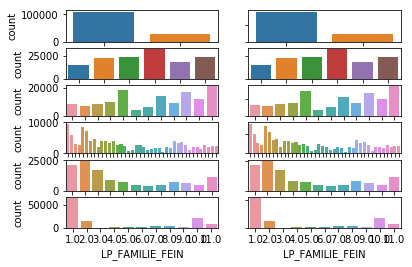

In [64]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_re_engineered_df = clean_data(customers_df, 35)
customers_re_engineered_df.info()
customers_scaled_data_df = scaler.transform(customers_re_engineered_df)
customers_pca_data_df = azdias_pca_reduced_dim.transform(customers_scaled_data_df)
customers_pca_means_predict = km.predict(customers_pca_data_df)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [65]:
df_pca_kmeans_pop = re_engineered_with_cleaning_funk.copy()
df_pca_kmeans_pop['Segment K-means'] = km.labels_

In [66]:
df_pca_kmeans_pop

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,Segment K-means
1,1.0,2,1,5,2,5,4,5,0,3.0,...,3.0,5.0,4.0,0,1,14.0,0,1,5,3
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,5.0,2.0,0,1,15.0,1,4,2,4
4,3.0,1,4,3,4,1,3,2,0,3.0,...,4.0,6.0,5.0,0,1,8.0,0,3,4,1
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,3.0,0,1,3.0,0,4,5,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,4.0,6.0,3.0,0,1,10.0,0,2,2,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,2.0,5.0,2.0,0,1,8.0,0,4,1,1
8,3.0,1,4,4,2,4,2,2,1,3.0,...,2.0,4.0,3.0,0,1,11.0,1,3,1,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,2.0,3.0,1.0,0,1,15.0,1,5,1,4
10,3.0,2,2,2,5,3,1,5,0,2.0,...,4.0,6.0,5.0,0,1,3.0,0,1,5,2
19,3.0,1,5,2,3,1,3,1,1,3.0,...,4.0,6.0,3.0,0,1,9.0,1,4,3,1


In [67]:
len(customers_pca_means_predict)

95675

In [68]:
df_pca_kmeans_cust = customers_re_engineered_df.copy()
df_pca_kmeans_cust['Segment K-means'] = customers_pca_means_predict

In [69]:
df_pca_kmeans_cust

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,Segment K-means
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,5.0,2.0,0,1,15.0,1,4,2,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,4.0,6.0,5.0,0,1,8.0,0,3,4,2
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,3.0,0,1,3.0,0,4,5,2
6,2.0,2,1,5,1,5,4,3,0,2.0,...,4.0,6.0,3.0,0,1,10.0,0,2,2,1
7,1.0,1,3,3,4,1,3,2,0,1.0,...,2.0,5.0,2.0,0,1,8.0,0,4,1,1
8,3.0,1,4,4,2,4,2,2,1,3.0,...,2.0,4.0,3.0,0,1,11.0,1,3,1,1
9,3.0,2,2,4,2,3,5,4,1,2.0,...,2.0,3.0,1.0,0,1,15.0,1,5,1,1
19,3.0,1,5,2,3,1,3,1,1,3.0,...,4.0,6.0,3.0,0,1,9.0,1,4,3,2
21,2.0,1,3,4,1,2,5,1,0,2.0,...,5.0,7.0,5.0,0,1,10.0,0,5,5,2
22,1.0,1,1,5,3,5,5,5,0,2.0,...,4.0,5.0,5.0,0,1,14.0,0,1,5,2


In [70]:
df_segm_analysis_pop = df_pca_kmeans_pop.groupby(['Segment K-means']).mean()
df_segm_analysis_cust = df_pca_kmeans_cust.groupby(['Segment K-means']).mean()
df_segm_analysis_pop

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,1.653314,1.554759,2.502332,4.020062,2.155184,4.128740,3.953217,2.767690,0.244465,2.214335,...,3.905288,2.805293,4.102157,2.590089,0.140692,0.859308,13.144645,0.244465,3.208923,2.636392
1,3.393377,1.000188,4.489290,1.734224,4.237661,1.824630,1.942346,2.193647,0.409519,2.218719,...,3.852605,2.849875,4.335090,2.681294,0.138190,0.861810,7.265901,0.409519,3.377838,2.491996
2,3.421924,1.532139,2.762608,1.950798,4.207548,2.000166,1.703757,4.019025,0.069896,2.204622,...,2.666432,3.689626,6.882152,3.745146,0.302580,0.697420,6.683801,0.069896,2.439606,4.385570
3,1.714537,1.493015,1.617319,4.302611,2.081847,3.695360,3.632246,3.890397,0.081011,2.294729,...,2.610360,3.713614,7.068723,3.754912,0.313889,0.686111,12.822424,0.081011,2.006253,4.442834
4,3.413225,2.000000,3.770720,1.837601,4.135428,2.634029,2.032501,2.823349,0.390382,2.110952,...,3.871949,2.824842,4.241087,2.646041,0.146743,0.853257,7.526999,0.390382,3.410567,2.457074


In [71]:
df_segm_analysis_cust

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,3.103721,1.738357,3.564083,2.315885,3.858853,2.918194,2.440342,2.929911,0.271505,2.256796,...,3.614532,2.625532,4.040924,2.408100,0.151684,0.848316,8.237620,0.271505,2.910692,2.429890
1,2.346994,1.359284,2.868973,3.080777,3.123148,3.010902,2.920412,3.119332,0.262055,2.354824,...,3.328807,2.973586,5.081520,2.778879,0.172853,0.827147,10.360821,0.262055,2.807176,3.369097
2,2.691440,1.467549,2.709632,2.860467,3.268829,2.670456,2.623657,3.357065,0.212214,2.178710,...,3.223559,3.656518,6.482993,3.770236,0.224313,0.775687,9.711715,0.212214,2.810543,3.921204
3,4.000000,2.000000,2.000000,1.000000,5.000000,1.000000,1.000000,5.000000,1.000000,1.000000,...,2.000000,4.000000,9.000000,3.000000,1.000000,0.000000,2.000000,1.000000,5.000000,4.000000
4,3.617714,1.498720,4.006176,1.598885,4.410604,2.028167,1.731586,2.794698,0.171713,1.807652,...,3.502485,2.590752,3.927549,2.348396,0.123513,0.876487,5.988552,0.171713,3.217201,2.490134


In [81]:
df_segm_analysis_cust['N Obs'] = df_pca_kmeans_cust[['Segment K-means', 'ALTERSKATEGORIE_GROB']].groupby(['Segment K-means']).count()
df_segm_analysis_cust['Prop Obs'] = df_segm_analysis_cust['N Obs'] / df_segm_analysis_cust['N Obs'].sum()

df_segm_analysis_pop['N Obs'] = df_pca_kmeans_pop[['Segment K-means', 'ALTERSKATEGORIE_GROB']].groupby(['Segment K-means']).count()
df_segm_analysis_pop['Prop Obs'] = df_segm_analysis_pop['N Obs'] / df_segm_analysis_pop['N Obs'].sum()

In [82]:
df_segm_analysis_cust

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,N Obs,Prop Obs
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,3.103721,1.738357,3.564083,2.315885,3.858853,2.918194,2.440342,2.929911,0.271505,2.256796,...,4.040924,2.408100,0.151684,0.848316,8.237620,0.271505,2.910692,2.429890,23727,0.247996
1,2.346994,1.359284,2.868973,3.080777,3.123148,3.010902,2.920412,3.119332,0.262055,2.354824,...,5.081520,2.778879,0.172853,0.827147,10.360821,0.262055,2.807176,3.369097,20179,0.210912
2,2.691440,1.467549,2.709632,2.860467,3.268829,2.670456,2.623657,3.357065,0.212214,2.178710,...,6.482993,3.770236,0.224313,0.775687,9.711715,0.212214,2.810543,3.921204,45129,0.471691
3,4.000000,2.000000,2.000000,1.000000,5.000000,1.000000,1.000000,5.000000,1.000000,1.000000,...,9.000000,3.000000,1.000000,0.000000,2.000000,1.000000,5.000000,4.000000,1,0.000010
4,3.617714,1.498720,4.006176,1.598885,4.410604,2.028167,1.731586,2.794698,0.171713,1.807652,...,3.927549,2.348396,0.123513,0.876487,5.988552,0.171713,3.217201,2.490134,6639,0.069391


In [83]:
df_segm_analysis_pop

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,N Obs,Prop Obs
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,1.653314,1.554759,2.502332,4.020062,2.155184,4.128740,3.953217,2.767690,0.244465,2.214335,...,4.102157,2.590089,0.140692,0.859308,13.144645,0.244465,3.208923,2.636392,108265,0.173722
1,3.393377,1.000188,4.489290,1.734224,4.237661,1.824630,1.942346,2.193647,0.409519,2.218719,...,4.335090,2.681294,0.138190,0.861810,7.265901,0.409519,3.377838,2.491996,127867,0.205175
2,3.421924,1.532139,2.762608,1.950798,4.207548,2.000166,1.703757,4.019025,0.069896,2.204622,...,6.882152,3.745146,0.302580,0.697420,6.683801,0.069896,2.439606,4.385570,150380,0.241299
3,1.714537,1.493015,1.617319,4.302611,2.081847,3.695360,3.632246,3.890397,0.081011,2.294729,...,7.068723,3.754912,0.313889,0.686111,12.822424,0.081011,2.006253,4.442834,114824,0.184246
4,3.413225,2.000000,3.770720,1.837601,4.135428,2.634029,2.032501,2.823349,0.390382,2.110952,...,4.241087,2.646041,0.146743,0.853257,7.526999,0.390382,3.410567,2.457074,121873,0.195557


In [84]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cluster_camparisom_table = PrettyTable()
cluster_camparisom_table.field_names = ['Cluster Id', \
                                        'Proportion in Population', \
                                        'Proportion  in Customers']
for cluster in range(0, 5):
    cluster_camparisom_table.add_row([cluster,\
                                      round(df_segm_analysis_pop['Prop Obs'].values[cluster], 6), \
                                      round(df_segm_analysis_cust['Prop Obs'].values[cluster], 6)])

print(cluster_camparisom_table)

+------------+--------------------------+--------------------------+
| Cluster Id | Proportion in Population | Proportion  in Customers |
+------------+--------------------------+--------------------------+
|     0      |         0.173722         |         0.247996         |
|     1      |         0.205175         |         0.210912         |
|     2      |         0.241299         |         0.471691         |
|     3      |         0.184246         |          1e-05           |
|     4      |         0.195557         |         0.069391         |
+------------+--------------------------+--------------------------+


In [87]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
df_segm_analysis_cust.loc[2]

ALTERSKATEGORIE_GROB                  2.691440
ANREDE_KZ                             1.467549
FINANZ_MINIMALIST                     2.709632
FINANZ_SPARER                         2.860467
FINANZ_VORSORGER                      3.268829
FINANZ_ANLEGER                        2.670456
FINANZ_UNAUFFAELLIGER                 2.623657
FINANZ_HAUSBAUER                      3.357065
GREEN_AVANTGARDE                      0.212214
HEALTH_TYP                            2.178710
LP_LEBENSPHASE_FEIN                  11.610273
LP_LEBENSPHASE_GROB                   3.589178
RETOURTYP_BK_S                        3.359104
SEMIO_SOZ                             4.346163
SEMIO_FAM                             4.228368
SEMIO_REL                             4.031421
SEMIO_MAT                             3.769727
SEMIO_VERT                            4.312615
SEMIO_LUST                            4.042966
SEMIO_ERL                             4.322786
SEMIO_KULT                            4.375834
SEMIO_RAT    

In [88]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
df_segm_analysis_cust.loc[3]


ALTERSKATEGORIE_GROB                4.00000
ANREDE_KZ                           2.00000
FINANZ_MINIMALIST                   2.00000
FINANZ_SPARER                       1.00000
FINANZ_VORSORGER                    5.00000
FINANZ_ANLEGER                      1.00000
FINANZ_UNAUFFAELLIGER               1.00000
FINANZ_HAUSBAUER                    5.00000
GREEN_AVANTGARDE                    1.00000
HEALTH_TYP                          1.00000
LP_LEBENSPHASE_FEIN                17.00000
LP_LEBENSPHASE_GROB                 5.00000
RETOURTYP_BK_S                      5.00000
SEMIO_SOZ                           5.00000
SEMIO_FAM                           3.00000
SEMIO_REL                           2.00000
SEMIO_MAT                           3.00000
SEMIO_VERT                          4.00000
SEMIO_LUST                          5.00000
SEMIO_ERL                           7.00000
SEMIO_KULT                          1.00000
SEMIO_RAT                           3.00000
SEMIO_KRIT                      

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.